In [280]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb
import pmdarima as pm

import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
import statsmodels.tsa.api as smt
from statsmodels.tools import eval_measures
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [281]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [282]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [283]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [284]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [285]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr_diff'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr2_diff'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr2_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_train', train0_df['FEDFUNDS_diff'], np.zeros(train0_df.shape[0]), train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS_diff'], np.zeros(test0_df.shape[0]), test0_df.shape[0],1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,0.0328,0.0279,0.9061,0.9519
1,ffef_tr_test,-13.6332,-13.9446,2.2484,1.4995
2,ffef_tr2_train,-0.3337,-0.3406,1.2494,1.1178
3,ffef_tr2_test,0.5059,0.4954,0.0759,0.2755
4,Naive_train,-0.0001,-0.0001,0.9369,0.9680
5,Naive_test,-0.0633,-0.0633,0.1634,0.4042


model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , None )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

In [286]:
t0_df[['FEDFUNDS_diff','ffef_tr','ffef_tr2']].head(20)

,FEDFUNDS_diff,ffef_tr,ffef_tr2
DATE,,,
1962-03-31,0.056667,6.272692,2.896301
1962-06-30,0.150000,6.403498,2.960170
1962-09-30,0.240000,6.318855,3.046512
1962-12-31,0.076667,5.849439,3.203780
1963-03-31,0.043333,5.705875,3.247023
1963-06-30,-0.003333,5.628261,3.235888
1963-09-30,0.366667,6.385039,3.360453
1963-12-31,0.123333,6.778638,3.636323
1964-03-31,0.010000,7.177027,3.810980


In [287]:
t0_df[['FEDFUNDS_diff','ffef_tr_diff','ffef_tr2_diff']].head(20)

,FEDFUNDS_diff,ffef_tr_diff,ffef_tr2_diff
DATE,,,
1962-03-31,0.056667,0.819163,0.635994
1962-06-30,0.150000,0.130806,0.063869
1962-09-30,0.240000,-0.084643,0.086343
1962-12-31,0.076667,-0.469416,0.157267
1963-03-31,0.043333,-0.143564,0.043244
1963-06-30,-0.003333,-0.077614,-0.011135
1963-09-30,0.366667,0.756778,0.124565
1963-12-31,0.123333,0.393598,0.275870
1964-03-31,0.010000,0.398389,0.174657


# Load Data

In [288]:
taylor_df = load_taylor()
taylor_df = taylor_df.query('DATE >= "1990-01-01"').copy()
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (107, 25)
test_df:  (27, 25)


In [289]:
#taylor_df['chair_name'].unique()
taylor_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'CPIAUCSL_PC1', 'Growth_g', 'Real_Interest_Rate', 'Output_Gap',
       'FEDFUNDS_CPIAUCNS_PC1', 'FEDFUNDS-1', 'FEDFUNDS_diff',
       'FEDFUNDS_CPIAUCNS_PC1-1', 'FEDFUNDS_CPIAUCNS_PC1_diff', 'gap_inf',
       'gap_gdp', 'gap_ue', 'ffef_tr', 'ffef_tr2', 'ffef_tr_diff',
       'ffef_tr2_diff', 'recession_flag', 'chair_name', 'chair_index'],
      dtype='object')

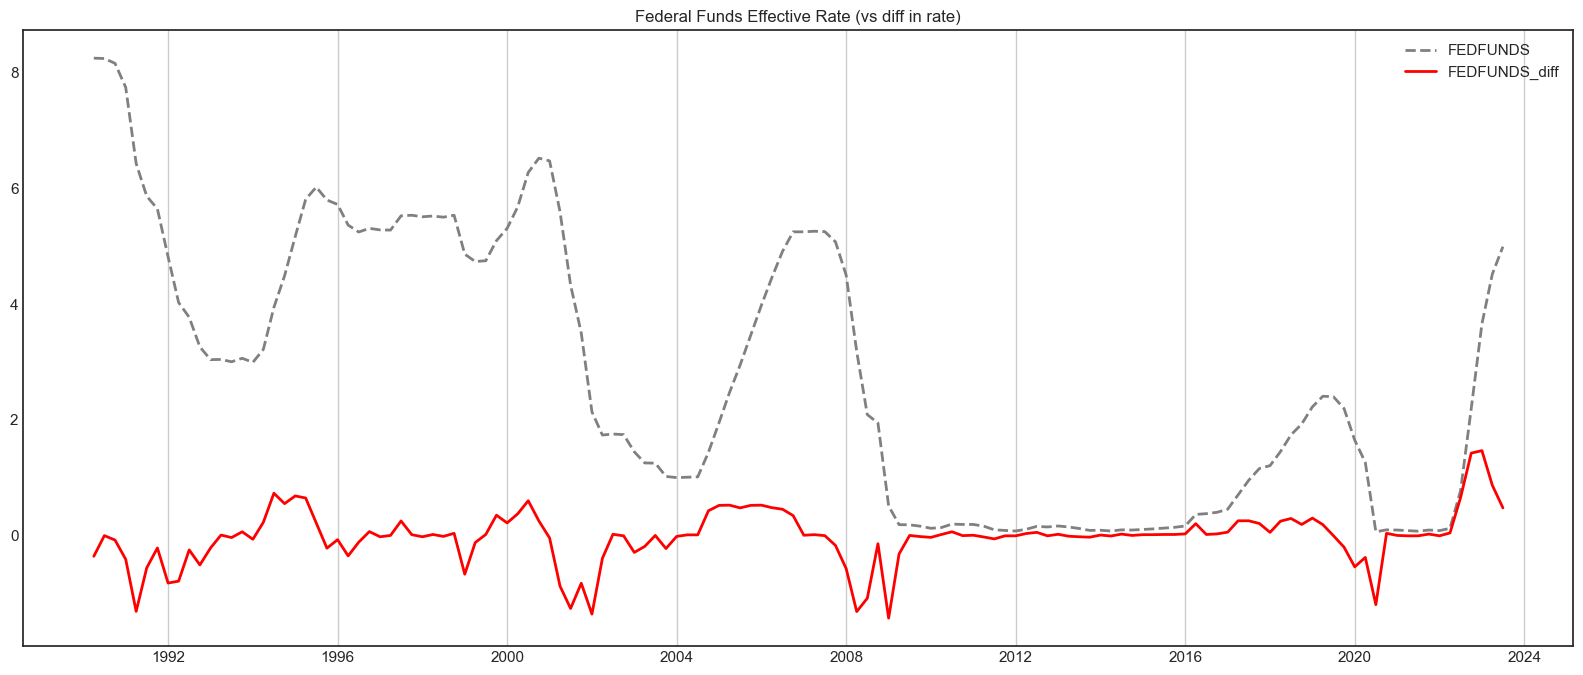

In [290]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_diff'], 'red', linewidth=2)
ax.legend(["FEDFUNDS","FEDFUNDS_diff"])
ax.set(title='Federal Funds Effective Rate (vs diff in rate)');
plt.show()

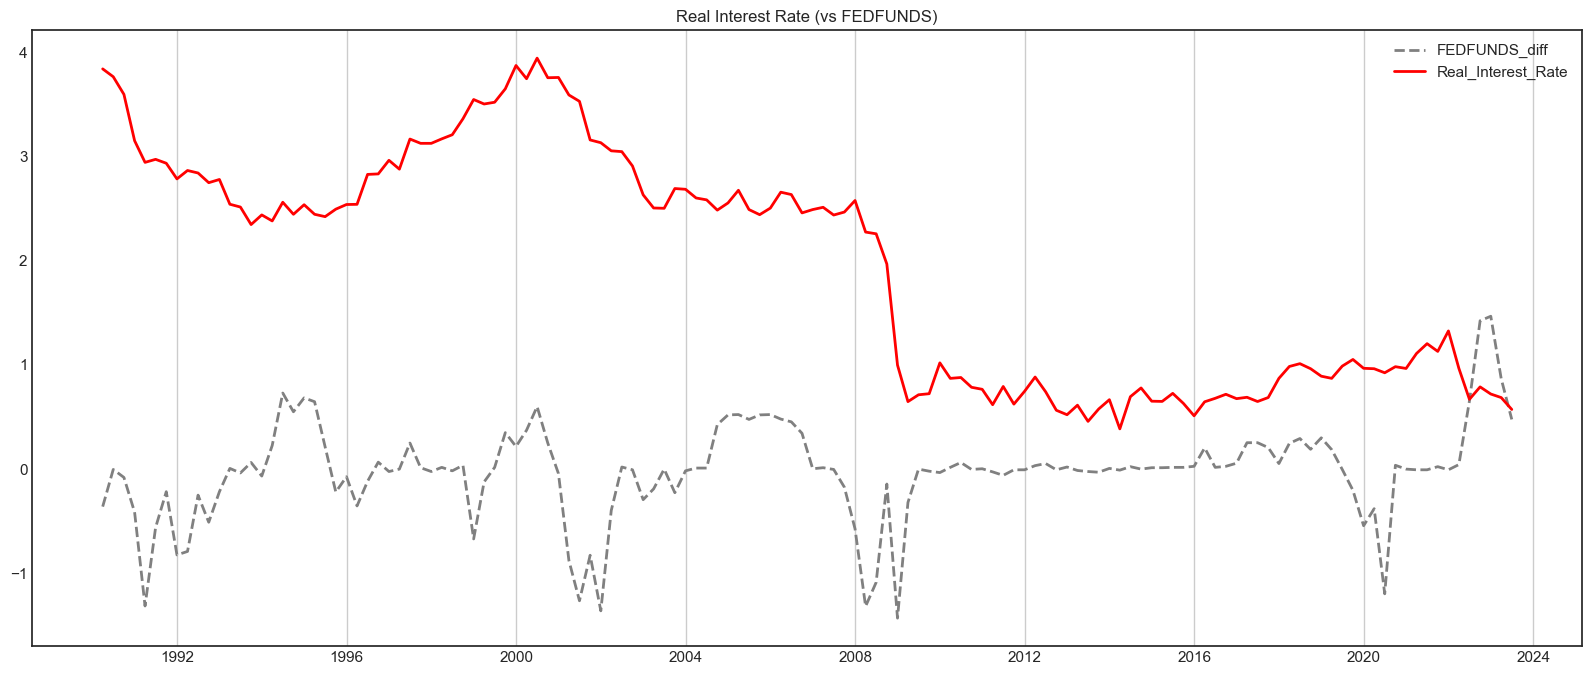

In [291]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_diff'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'red', linewidth=2)
ax.legend(["FEDFUNDS_diff","Real_Interest_Rate"])
ax.set(title='Real Interest Rate (vs FEDFUNDS)');
plt.show()

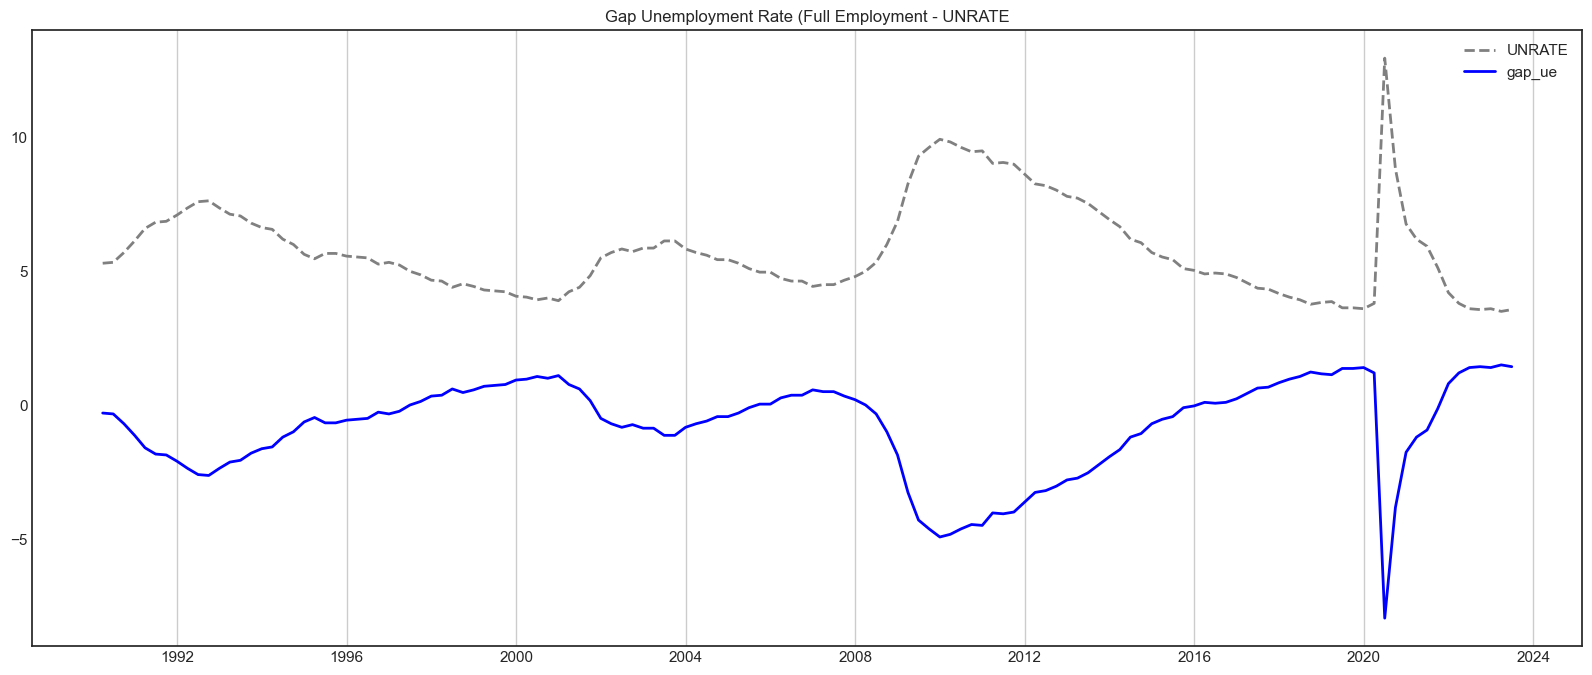

In [292]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['UNRATE'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_ue'], 'blue', linewidth=2)
ax.legend(["UNRATE","gap_ue"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

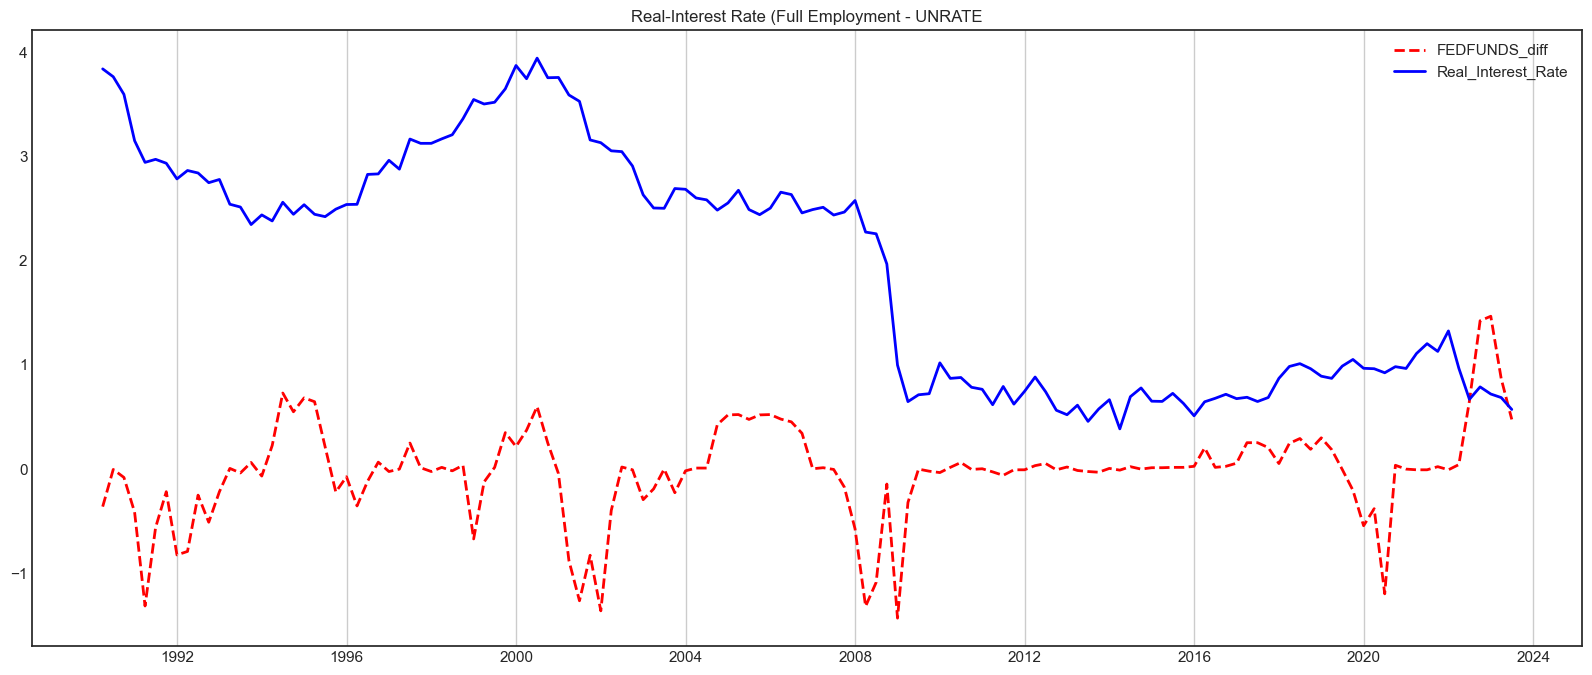

In [293]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_diff'], 'red', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS_diff","Real_Interest_Rate"])
ax.set(title='Real-Interest Rate (Full Employment - UNRATE');
plt.show()

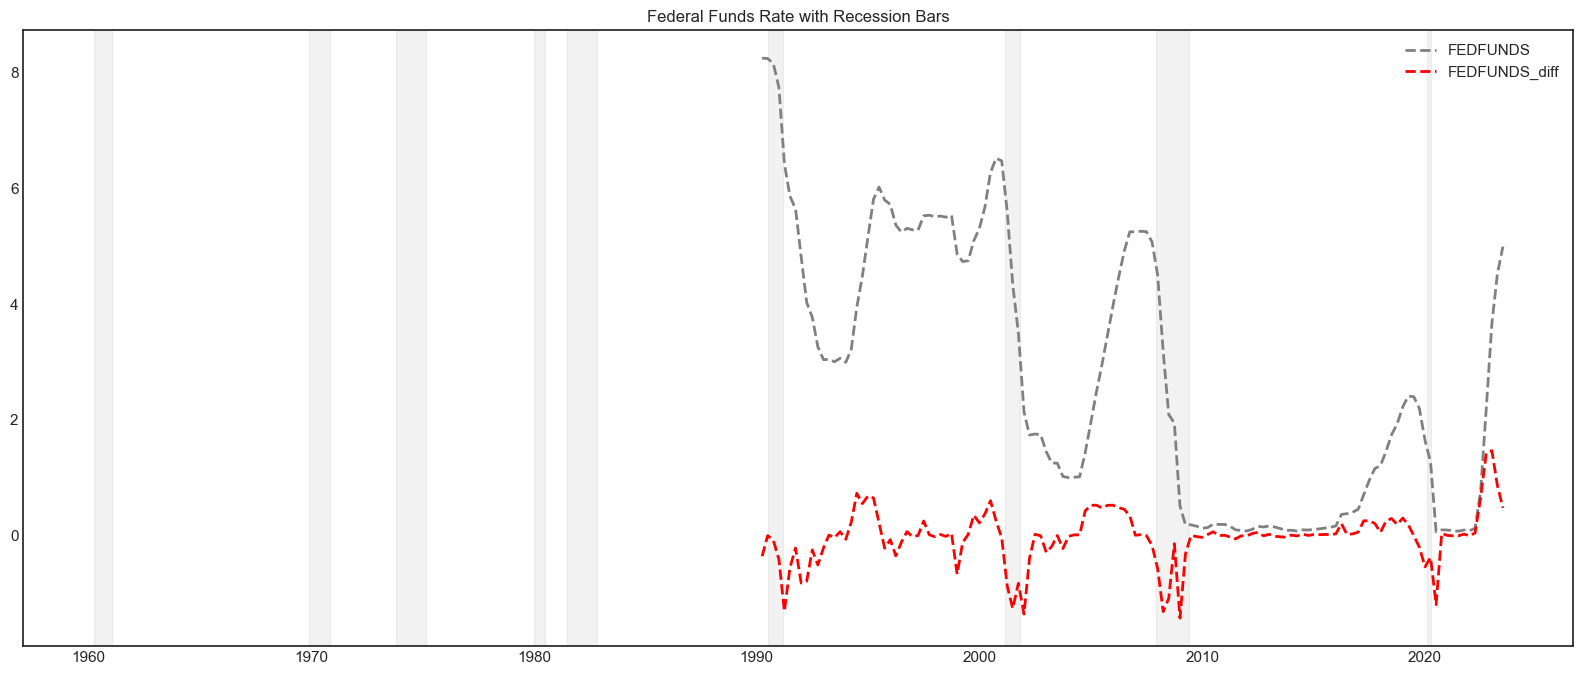

In [294]:
cycol = cycle('rgbcmyk')


t_df = taylor_df.query('DATE >= "1960-01-01"')
r_df = get_recession()
r_df = r_df.query('Peak_Date >= "1960-01-01"')

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(t_df.index, t_df['FEDFUNDS_diff'], linestyle='--', color='red',linewidth=2)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
   
ax.legend(["FEDFUNDS","FEDFUNDS_diff"])
ax.set(title='Federal Funds Rate with Recession Bars');
plt.show()

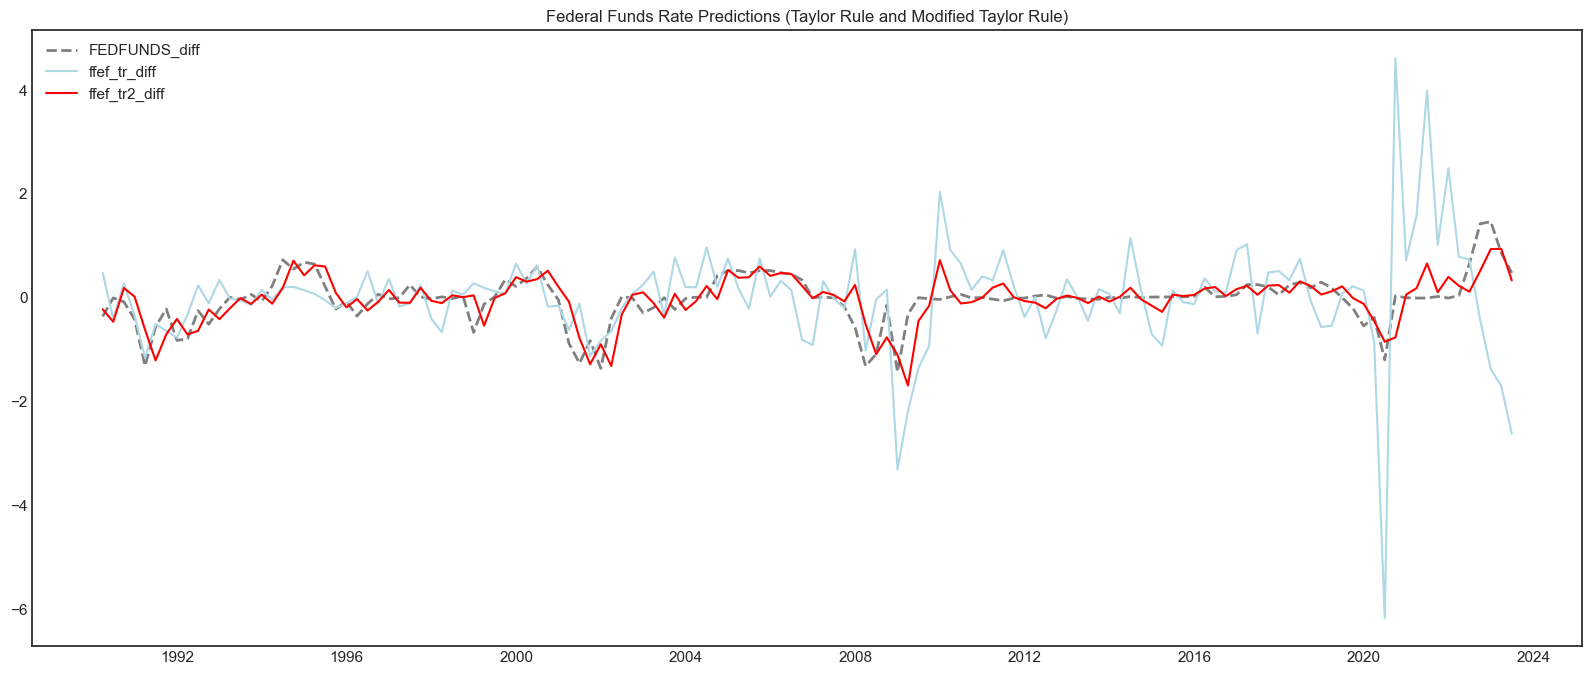

In [295]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plo3
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_diff'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['ffef_tr_diff'], color='lightblue', linewidth=1.5)
ax.plot(taylor_df.index, taylor_df['ffef_tr2_diff'], color='red', linewidth=1.5)

ax.legend(["FEDFUNDS_diff", "ffef_tr_diff","ffef_tr2_diff"])
ax.set(title='Federal Funds Rate Predictions (Taylor Rule and Modified Taylor Rule)');

plt.show()

# Case

In [296]:
#test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag', 'CPIAUCSL_PC1']]

In [297]:
#case = 1  # Full Model
#case = 2  # Modified Taylor Rule
#case = 3  # Recession Model
#case = 4  # Simple Model
case = 5  # Recession Model
#case = 6  # Full Model
#case = None  # Feature Selection

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    
    print('-- Full Model (Lasso Base)')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag', 'CPIAUCSL_PC1']]
    #X_train = train_df[['gap_inf', 'gap_gdp','recession_flag']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag', 'CPIAUCSL_PC1']]
    #X_test = test_df[[ 'gap_inf', 'gap_gdp','recession_flag']]
    y_test = test_df['FEDFUNDS_diff']

    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    #num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_gdp','CPIAUCSL_PC1']
    num_columns_lst = ['gap_inf', 'gap_gdp']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')

    
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 2:
    
    print('-- Modified Taylor Rule')
    #X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    X_train = train_df[['gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS_diff']


    #X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    X_test = test_df[['gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    #num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    num_columns_lst = ['gap_inf', 'gap_ue','Real_Interest_Rate']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
    
    
    
elif case == 3:
    print('-- Recession Model')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1','Real_Interest_Rate']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

elif case == 4:
    print('-- Simplified Model')
    X_train = train_df[['FEDFUNDS_CPIAUCNS_PC1-1', 'gap_inf', 'gap_ue']]
    #X_train = train_df[['gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS_CPIAUCNS_PC1']


    X_test = test_df[['FEDFUNDS_CPIAUCNS_PC1-1', 'gap_inf', 'gap_ue']]
    #X_test = test_df[['gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS_CPIAUCNS_PC1']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS_CPIAUCNS_PC1-1','gap_inf', 'gap_ue']
    #num_columns_lst = ['gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )

    
elif case == 5:
    print('-- Recession Model (minus Real Interest Rates)')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS_CPIAUCNS_PC1-1']]
    y_train = train_df['FEDFUNDS_CPIAUCNS_PC1']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS_CPIAUCNS_PC1-1']]
    y_test = test_df['FEDFUNDS_CPIAUCNS_PC1']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS_CPIAUCNS_PC1-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 6:
    print('-- Feature Selection')
    X_train = train_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','Real_Interest_Rate','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

elif case == 7:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )  
    
else:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS_CPIAUCNS_PC1-1']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS_CPIAUCNS_PC1_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS_CPIAUCNS_PC1-1']]
    #X_test = X_test + 10
    y_test = test_df['FEDFUNDS_CPIAUCNS_PC1_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    scaler_num = Normalizer()
    #scaler_num = PowerTransformer()
    #scaler_num = PowerTransformer(method='box-cox')
    #scaler_num = FunctionTransformer(np.log1p, validate=True)
    #scaler_num = QuantileTransformer(random_state=rand_int)

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','FEDFUNDS_CPIAUCNS_PC1-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )    


-- Recession Model (minus Real Interest Rates)


In [298]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
feature_names = t_fit.get_feature_names_out()
X_train_trf.columns = feature_names
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)



X_train_trf:  (107, 4)


# Stats Model - OLS

In [299]:
X_train_const = sm.add_constant(X_train_trf)

In [300]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     FEDFUNDS_CPIAUCNS_PC1   R-squared:                       0.888
Model:                               OLS   Adj. R-squared:                  0.884
Method:                    Least Squares   F-statistic:                     203.1
Date:                   Thu, 30 Nov 2023   Prob (F-statistic):           1.22e-47
Time:                           08:30:16   Log-Likelihood:                -106.19
No. Observations:                    107   AIC:                             222.4
Df Residuals:                        102   BIC:                             235.7
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.5112      0.075      6.857      0.000       0.363       0.659
num__gap_inf                               -0.2331      0.083     -2.825      0.006      -0.397      -0.069
num__gap_ue                                 0.2561      0.103      2.494      0.014       0.052       0.460
num__FEDFUNDS_CPIAUCNS_PC1-1                3.2258      0.147     21.902      0.000       2.934       3.518
cat__onehotencoder__recession_flag_True    -0.4975      0.225     -2.212      0.029      -0.944      -0.051
==============================================================================
Omnibus:                       11.286   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.545
Skew:                          -0.219   Prob(JB):                     1.04e-06
Kurtosis:                       5.447   Cond. No.                         3.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [301]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [302]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

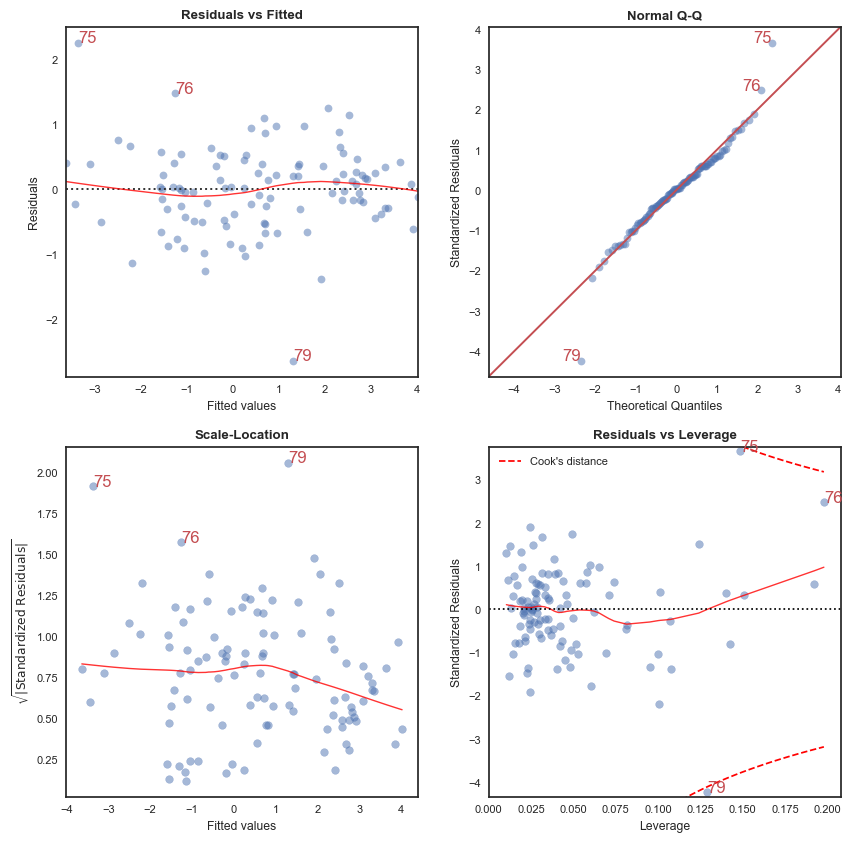

                                  Features  VIF Factor
0                                    const    1.330420
1                             num__gap_inf    1.175271
2                              num__gap_ue    1.525010
3             num__FEDFUNDS_CPIAUCNS_PC1-1    1.526829
4  cat__onehotencoder__recession_flag_True    1.116468


In [303]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

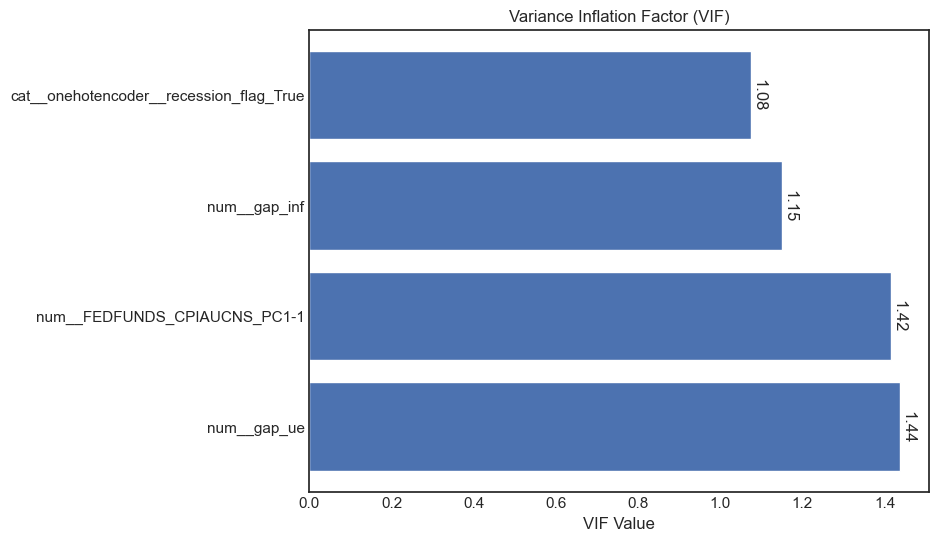

In [304]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_trf.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_trf.values, i) for i in range(X_train_trf.shape[1])]


# Sort the VIF values for plotting
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=False)

# Create a bar plot for VIF values
plt.figure(figsize=(8, 6))
plt.barh(vif_data_sorted['Variable'], vif_data_sorted['VIF'])

# Add vertical labels to the bars
for i, value in enumerate(vif_data_sorted['VIF']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)
    
plt.xlabel('VIF Value')
plt.title('Variance Inflation Factor (VIF)')
plt.show()

In [305]:
# Get the residuals from the fitted model
residuals = ols_result.resid

# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.9706746935844421
Shapiro-Wilk p-value: 0.018089


In [306]:
# White's Test: A significant p-value suggests the presence of heteroscedasticity.

white_test = het_white(ols_result.resid,  ols_result.model.exog)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
wt_df = pd.DataFrame(zip(labels, white_test))
wt_df.columns = ['name', 'value']
round(wt_df,4)

,name,value
0,Test Statistic,61.5485
1,Test Statistic p-value,0.0000
2,F-Statistic,9.6874
3,F-Test p-value,0.0000


## Test

In [307]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (27, 5)


In [308]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(27, 6)

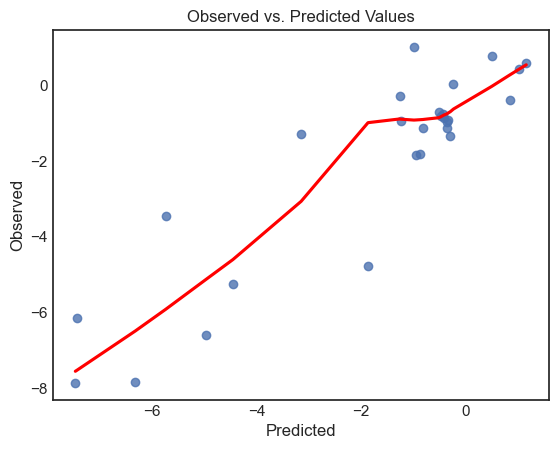

In [309]:
fitted_vals = test_pred_ols['mean']
resids = y_test - test_pred_ols['mean']


fig, ax = plt.subplots(1)

sns.regplot(x=fitted_vals, y=y_test, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

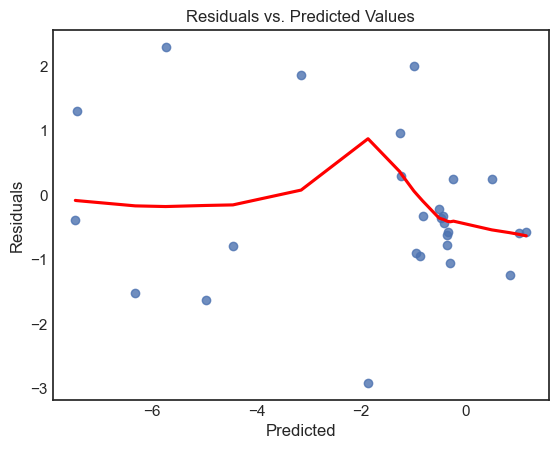

In [310]:
fig, ax = plt.subplots(1)
sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

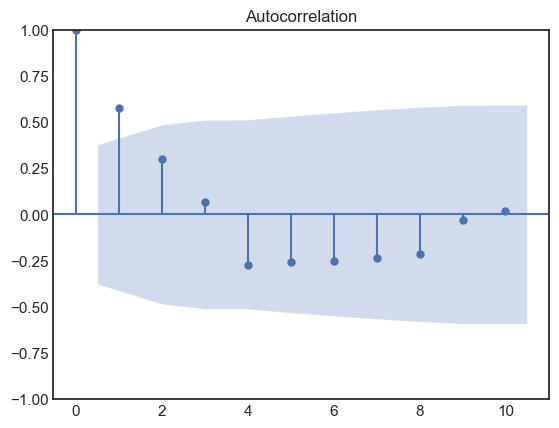

In [311]:
acf = smt.graphics.plot_acf(resids, lags=10 , alpha=0.05)
acf.show()

In [312]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

# Generalized Linear Model

In [313]:
X_train_const = sm.add_constant(X_train_trf)

In [314]:
#glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian(link=sm.families.links.log()))
glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian(link=sm.families.links.inverse_power()))

glm_result = glm_model.fit(attach_wls=True,atol=1e-10)

glm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                   
=================================================================================
Dep. Variable:     FEDFUNDS_CPIAUCNS_PC1   No. Observations:                  107
Model:                               GLM   Df Residuals:                      102
Model Family:                   Gaussian   Df Model:                            4
Link Function:             inverse_power   Scale:                          2.3151
Method:                             IRLS   Log-Likelihood:                -194.24
Date:                   Thu, 30 Nov 2023   Deviance:                       236.14
Time:                           08:30:16   Pearson chi2:                     236.
No. Iterations:                       49   Pseudo R-squ. (CS):             0.5017
Covariance Type:               nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       1.4900      0.313      4.756      0.000       0.876       2.104
num__gap_inf                               -0.0744      0.050     -1.477      0.140      -0.173       0.024
num__gap_ue                                -0.4825      0.209     -2.304      0.021      -0.893      -0.072
num__FEDFUNDS_CPIAUCNS_PC1-1               -1.0498      0.268     -3.911      0.000      -1.576      -0.524
cat__onehotencoder__recession_flag_True     0.1774      0.301      0.589      0.556      -0.413       0.768
===========================================================================================================
"""

infl = glm_result.get_influence(observed=False)

summ_df = infl.summary_frame()
#summ_df.sort_values("cooks_d", ascending=False)[:10]

fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

plt.show()

In [315]:
train_pred_glm = glm_result.predict(X_train_const)

t = glm_result.get_prediction(X_train_const)
train_pred_glm = t.summary_frame(alpha=0.05)

In [316]:
model_stats_df = model_results('glm_train', y_train, train_pred_glm['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [317]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (27, 5)


In [318]:
t = glm_result.get_prediction(X_test_const)
test_pred_glm = t.summary_frame(alpha=0.05)
test_pred_glm.shape

(27, 4)

In [319]:
model_stats_df = model_results('glm_test', y_test, test_pred_glm['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,0.0328,0.0279,0.9061,0.9519
1,ffef_tr_test,-13.6332,-13.9446,2.2484,1.4995
2,ffef_tr2_train,-0.3337,-0.3406,1.2494,1.1178
3,ffef_tr2_test,0.5059,0.4954,0.0759,0.2755
4,Naive_train,-0.0001,-0.0001,0.9369,0.9680
5,Naive_test,-0.0633,-0.0633,0.1634,0.4042
6,ols_train,0.8884,0.8852,0.4261,0.6528
7,ols_test,0.7935,0.7665,1.3593,1.1659
8,glm_train,0.4222,0.4054,2.2069,1.4856
9,glm_test,-0.9193,-1.1697,12.6329,3.5543


# Lasso

In [320]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.008569089107145917


In [321]:
pipe_lasso = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',linear_model.LassoCV(cv=5, 
                                                                           #alphas=[0.001, 0.01,0.05, 0.1, 0.5],
                                                                           random_state=rand_int, 
                                                                           max_iter=10000))]
)

param_lasso = {
    #'model__alpha': [0.01, 0.05, 0.1, 0.5],
    'model__verbose': [0],
}


cv = RandomizedSearchCV(estimator = pipe_lasso, 
                        param_distributions = param_lasso,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('Lasso', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

Lasso ) Best Accuracy Score: 0.27129539053023055 Parameters: {} {'model__verbose': 0}


In [322]:
lasso_best = linear_model.Lasso(alpha=cv.best_estimator_.named_steps.model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [323]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,coef
num__FEDFUNDS_CPIAUCNS_PC1-1,3.201078
cat__onehotencoder__recession_flag_True,-0.407599
num__gap_ue,0.246519
num__gap_inf,-0.225769


In [324]:
feature_df.index

Index(['num__FEDFUNDS_CPIAUCNS_PC1-1',
       'cat__onehotencoder__recession_flag_True', 'num__gap_ue',
       'num__gap_inf'],
      dtype='object')

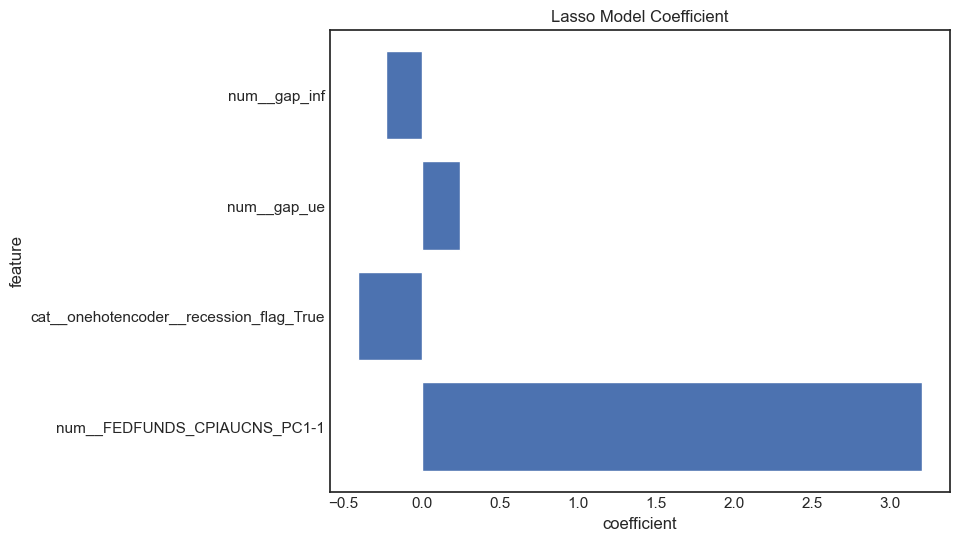

In [325]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

### linearity assumption Interpretation:
Ideally, the scatter plot should show a strong linear relationship along the diagonal line (y = x). This indicates that the model's predictions are close to the actual values.
A scattered or disperse pattern away from the diagonal line might indicate areas where the model performs poorly, potentially highlighting non-linearity or other issues in the model.

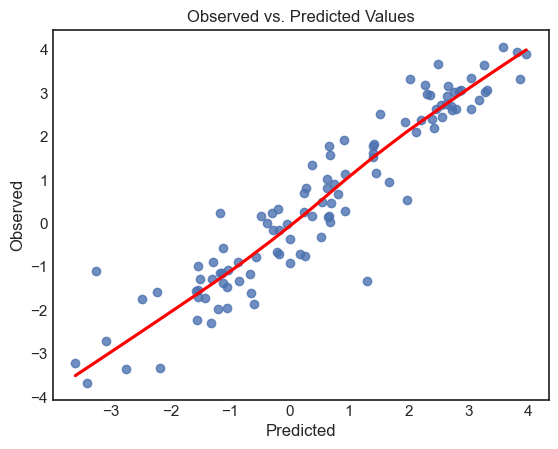

In [326]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### independence of residuals Iterpretation:
In the scatter plot(s), check for a consistent spread of residuals around zero. If the spread of residuals widens or narrows systematically as predicted values or predictor values change, it suggests heteroscedasticity, violating the assumption of homoscedasticity.

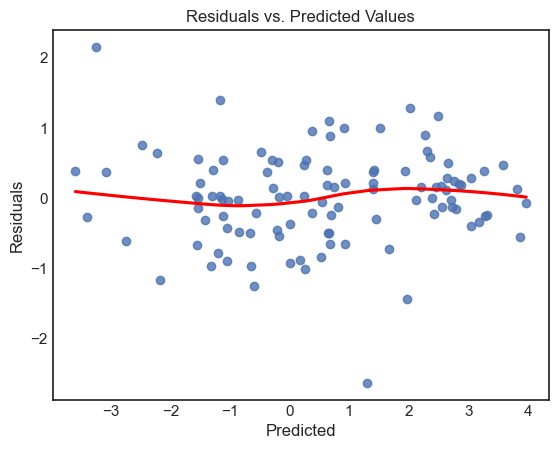

In [327]:
# independence of residuals

residuals = y_train - train_pred_lasso

fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

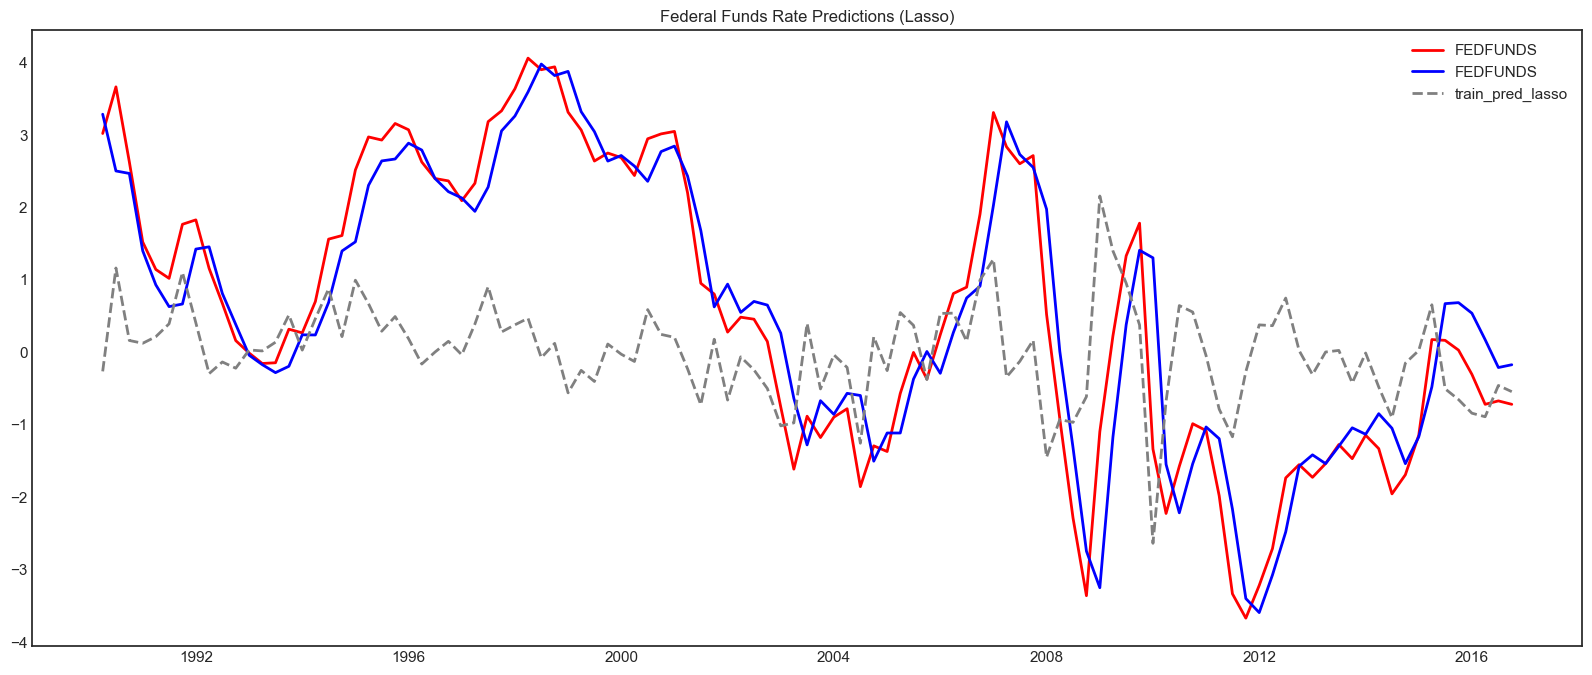

In [328]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(y_train.index, y_train, 'lightgray', color='red',linewidth=2)
ax.plot(y_train.index, train_pred_lasso, 'lightgray', color='blue',linewidth=2)
ax.plot(y_train.index, residuals, 'lightgray', linestyle="--",color='gray',linewidth=2)


ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

In [329]:
# values for durbin watson test is between 0 and 4 the value close to 2 is accurate
# Durbin-Watson Test: Provides a measure (statistic) that ranges from 0 to 4. A value around 2 
# suggests no autocorrelation. Values closer to 0 indicate positive autocorrelation, 
# while values near 4 suggest negative autocorrelation.

durbin_watson_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", durbin_watson_stat)

Durbin-Watson statistic: 1.2607112368040743


In [330]:
# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# p-value < 0.05 - reject the null hypothesis residuals are not normally distrivuted
# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,8))


# Check for normality based on the p-value
alpha = 0.05  # Set a significance level
if shapiro_test.pvalue > alpha:
    print("Sample looks Gaussian (fail to reject H0 - data is normally distributed)")
else:
    print("Sample does not look Gaussian (reject H0 - data is not normally distributed)")

Shapiro-Wilk Test Statistic: 0.973087728023529
Shapiro-Wilk p-value: 0.0284723
Sample does not look Gaussian (reject H0 - data is not normally distributed)


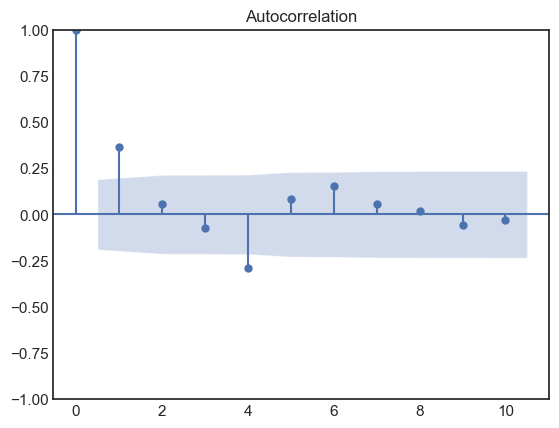

In [331]:
acf = smt.graphics.plot_acf(residuals, lags=10 , alpha=0.05)
acf.show()

In [332]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], X_train.shape[1] , model_stats_df )

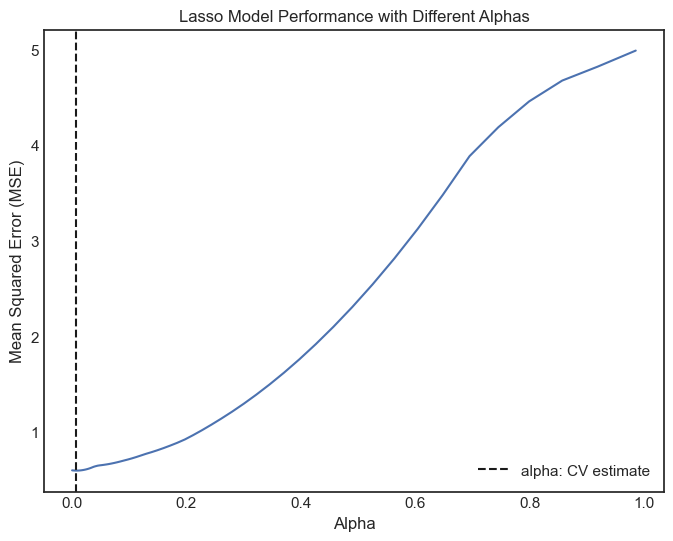

In [333]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

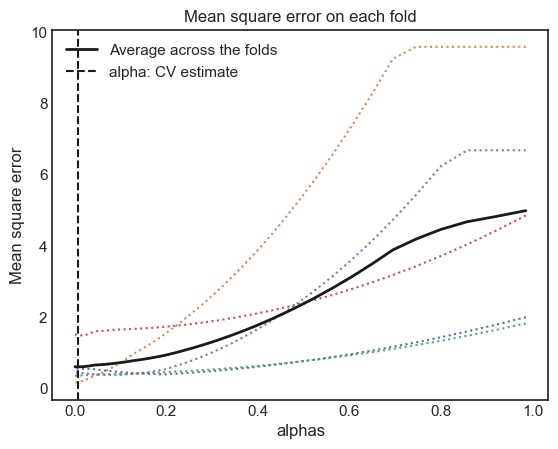

In [334]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")
plt.show()
#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

## Test

In [335]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_const: ', X_test_trf.shape)

X_test_const:  (27, 4)


In [336]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (27,)


In [337]:
residuals = y_test - test_pred_lasso

In [338]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

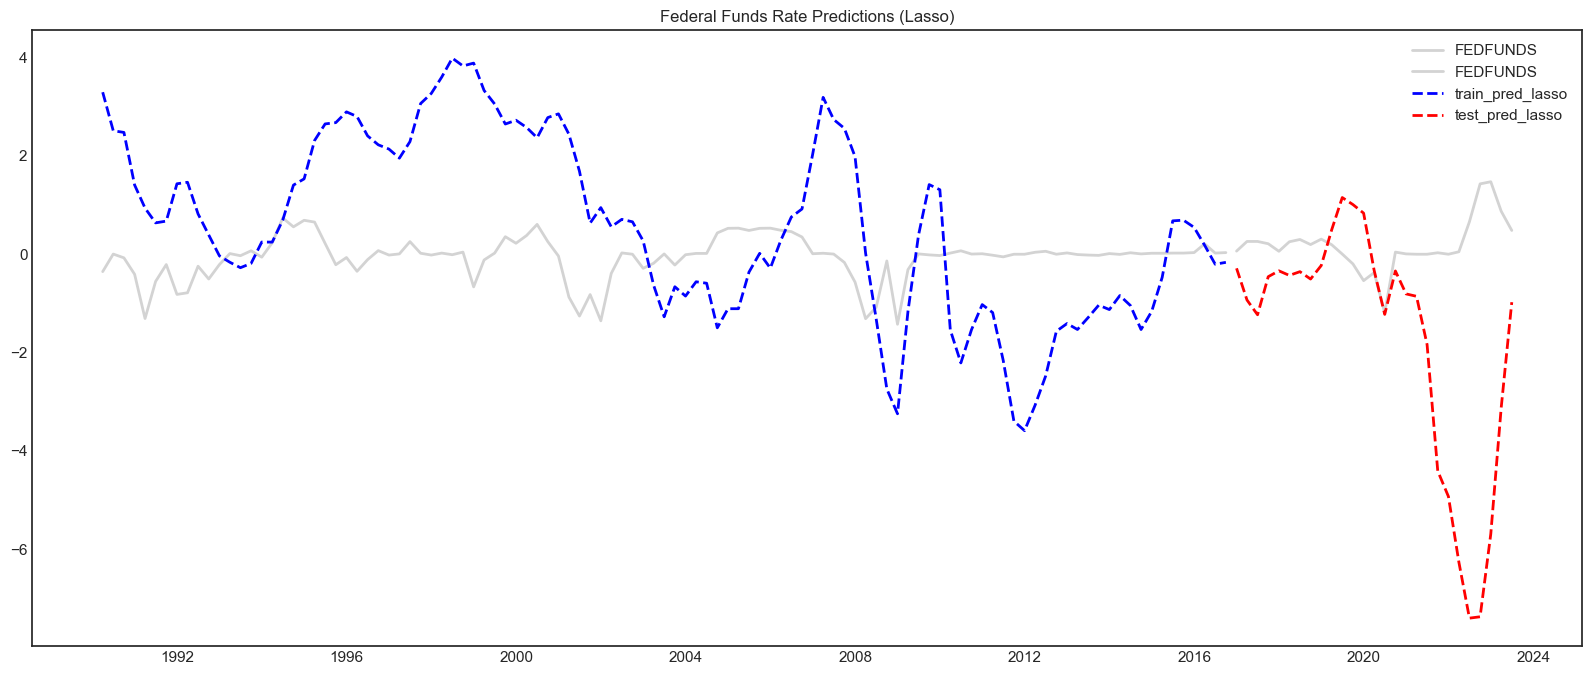

In [339]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(train_df.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_df.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

## Sharpe

In [340]:
model = cv.best_estimator_.named_steps.model
model

LassoCV(cv=5, max_iter=10000, random_state=12, verbose=0)

In [341]:
explainer = None
shap_values = None

In [342]:
try:
    explainer = shap.Explainer(lasso_best, X_test_trf)
    shap_values = explainer(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

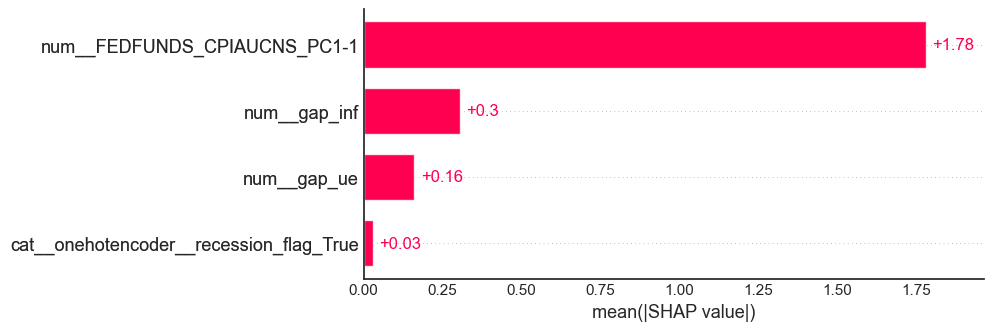

In [343]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

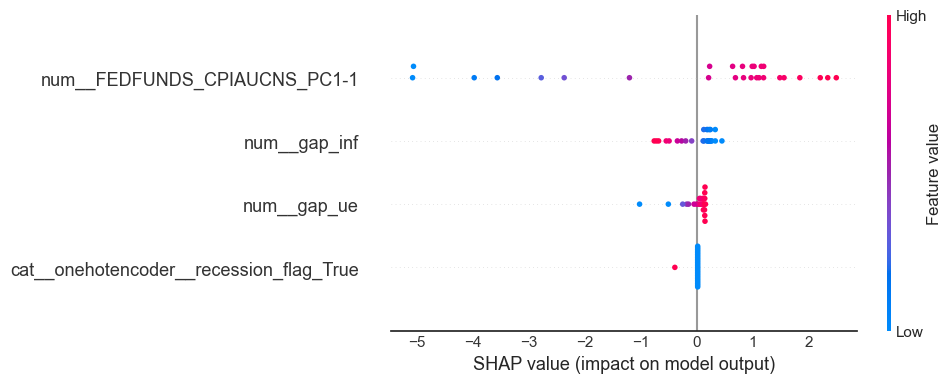

In [344]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(10,4))

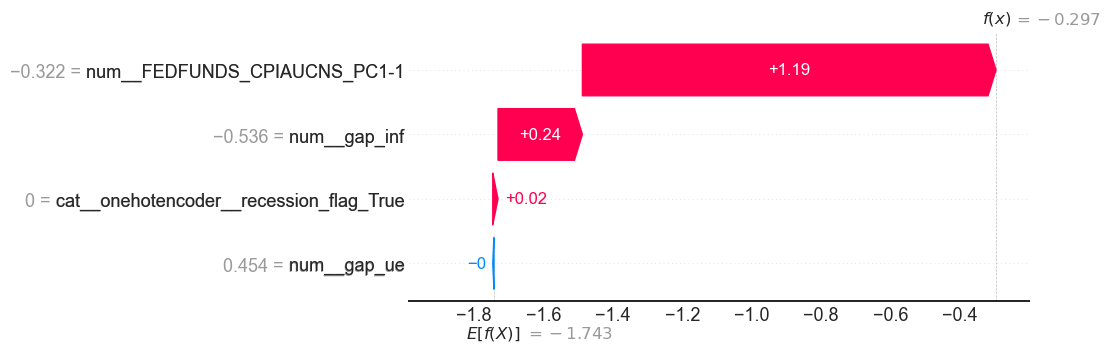

In [345]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


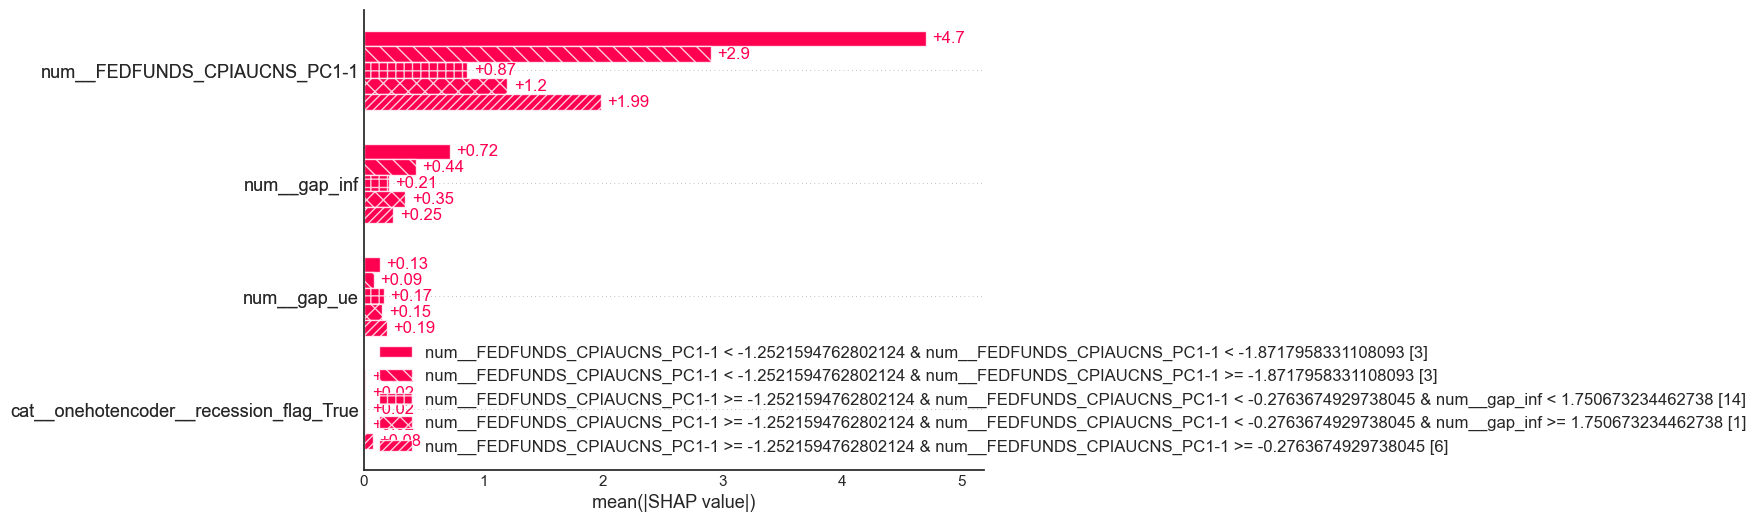

In [346]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [347]:
shap.force_plot(shap_values, plot_cmap = "PkYg")

if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__gap_ue"])

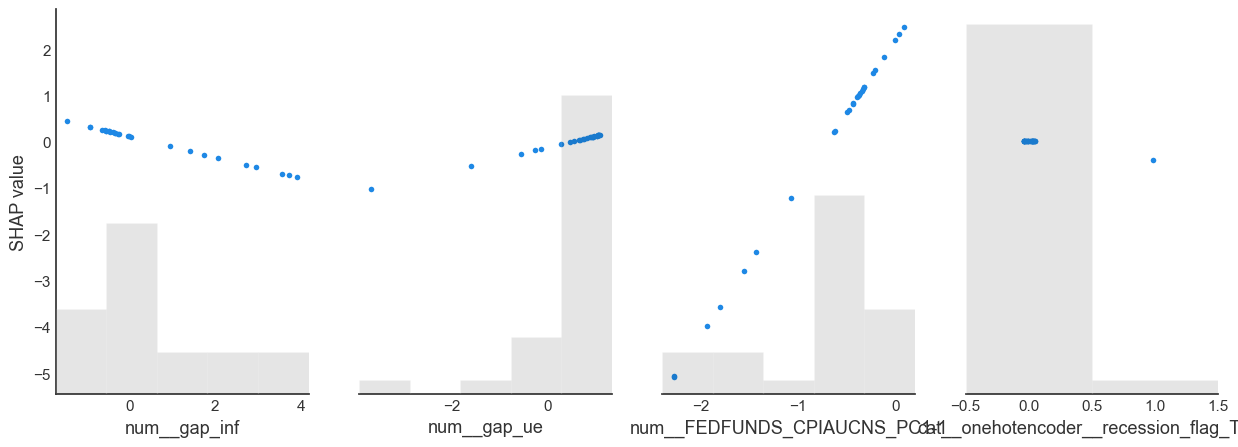

In [348]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)

# LGBM

In [349]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: -0.04258327794034924 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.020404898976033085, 'model__max_depth': 4, 'model__min_data_in_leaf': 10, 'model__n_estimators': 260, 'model__num_leaves': 49, 'model__reg_alpha': 0.07714526452120027, 'model__verbose': -1}


In [350]:
cv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler_num',
                                                                   RobustScaler()),
                                                                  ('imp_num',
                                                                   SimpleImputer())]),
                                                  ['gap_inf', 'gap_ue',
                                                   'FEDFUNDS_CPIAUCNS_PC1-1']),
                                                 ('cat',
                                                  Pipeline(steps=[('transformer',
                                                                   ColumnTransformer(transformers=[('onehotencoder',
                                                                                                    OneHotEncoder(categories=[[False,
                                                                                                                               True]],
                                                                                                                  drop='first',
                                                                                                                  handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    ['recession_flag'])]))]),
                                                  ['recession_flag'])])),
                ('model',
                 LGBMRegressor(eval_metric='r2_score',
                               learning_rate=0.020404898976033085, max_depth=4,
                               min_data_in_leaf=10, n_estimators=260,
                               num_leaves=49, reg_alpha=0.07714526452120027,
                               verbose=-1))])

In [351]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [352]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

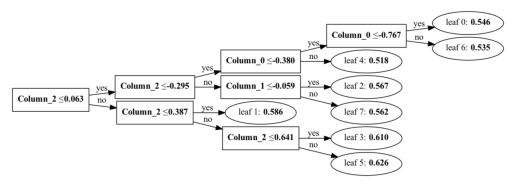

In [353]:
ltb.plot_tree(cv.best_estimator_.named_steps.model)
plt.show()

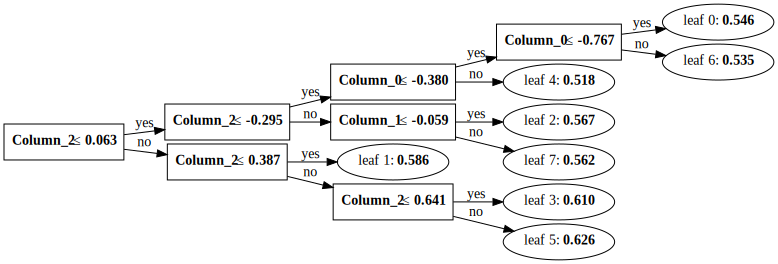

In [354]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [355]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})
feature_df.sort_values(by=['feature_importance'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,feature_name,feature_importance
2,num__FEDFUNDS_CPIAUCNS_PC1-1,582
0,num__gap_inf,575
1,num__gap_ue,374
3,cat__onehotencoder__recession_flag_True,59


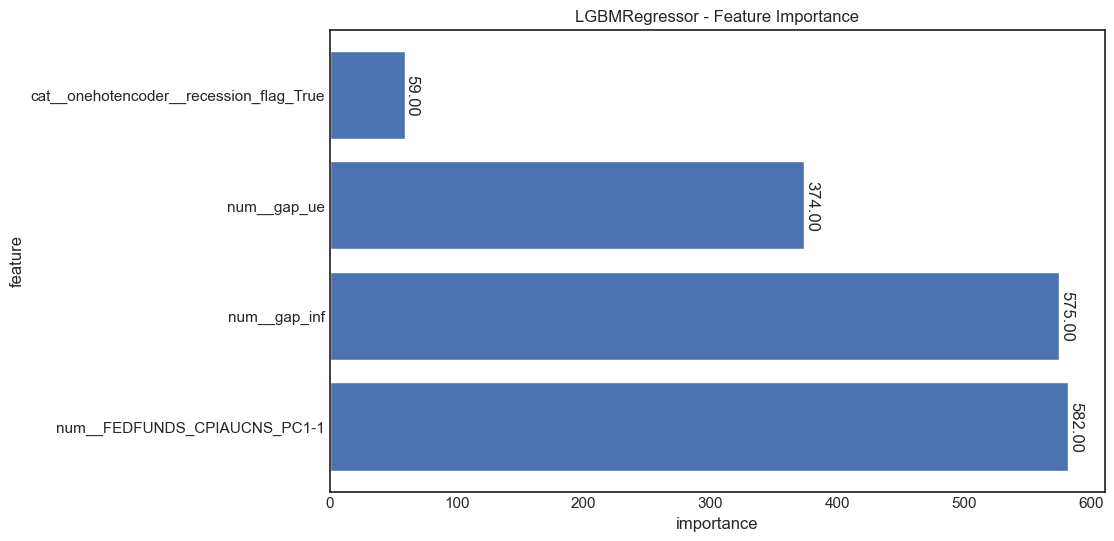

In [356]:
plt.figure(figsize=(10, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

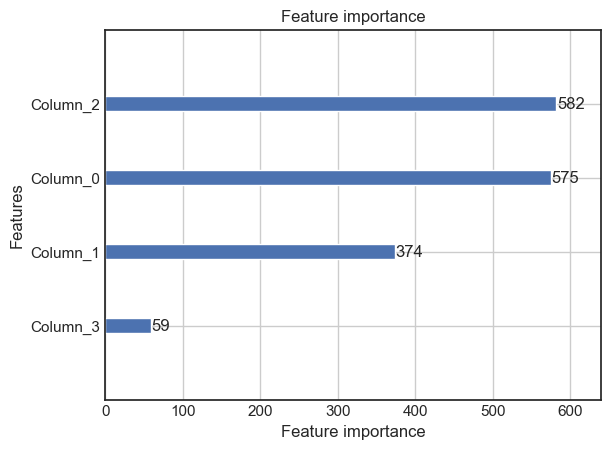

In [357]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [358]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [359]:
test_pred_lgbm = cv.best_estimator_.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(27,)

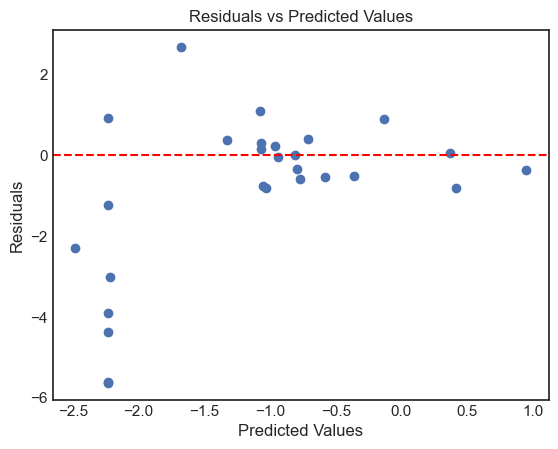

In [360]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_lgbm, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [361]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

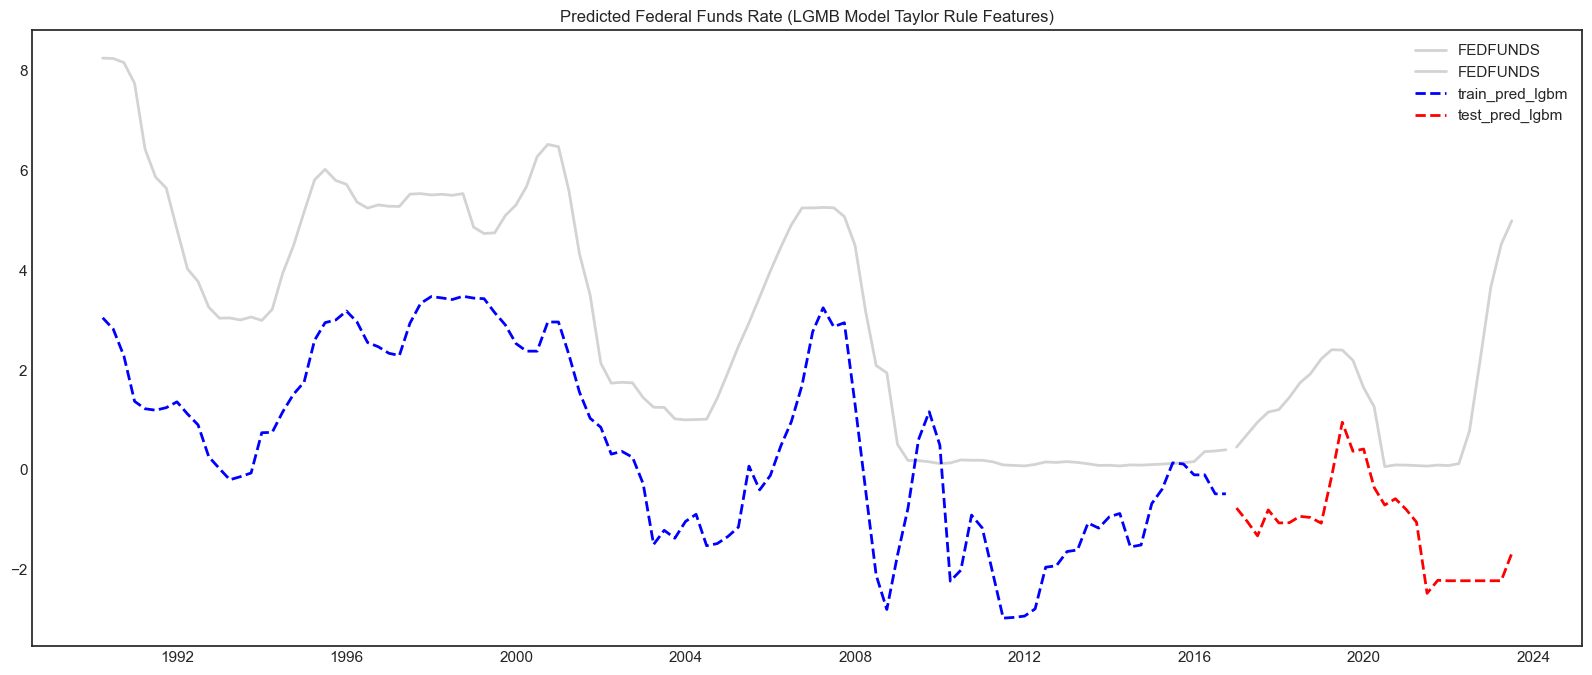

In [362]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Predicted Federal Funds Rate (LGMB Model Taylor Rule Features)');
plt.show()

# Sharpe

In [363]:
model = cv.best_estimator_.named_steps.model
model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [364]:
explainer = None
shap_values = None

In [365]:
try:
    explainer = shap.Explainer(lasso_best, X_test_trf)
    shap_values = explainer(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

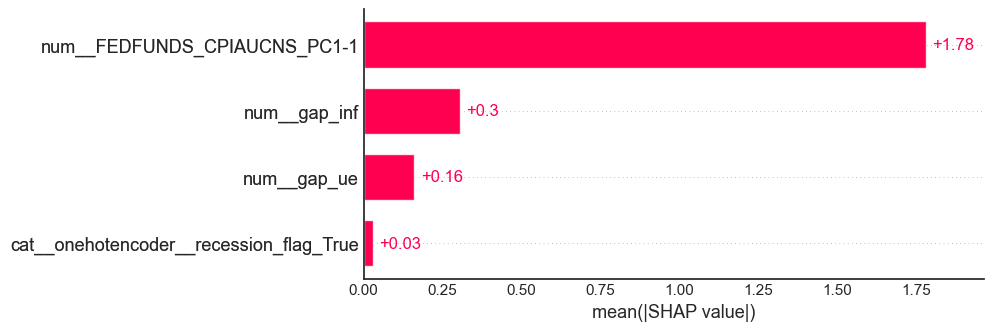

In [366]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

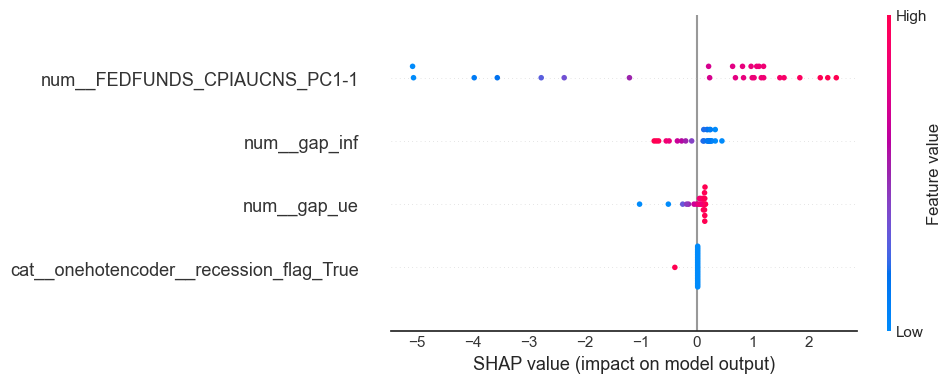

In [367]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(10,4))

try:
    if (shap_values is not None):
        shap.plots.waterfall(shap_values[0], max_display=20)
except Exception as e:
    print('-- error ')
    print(e)

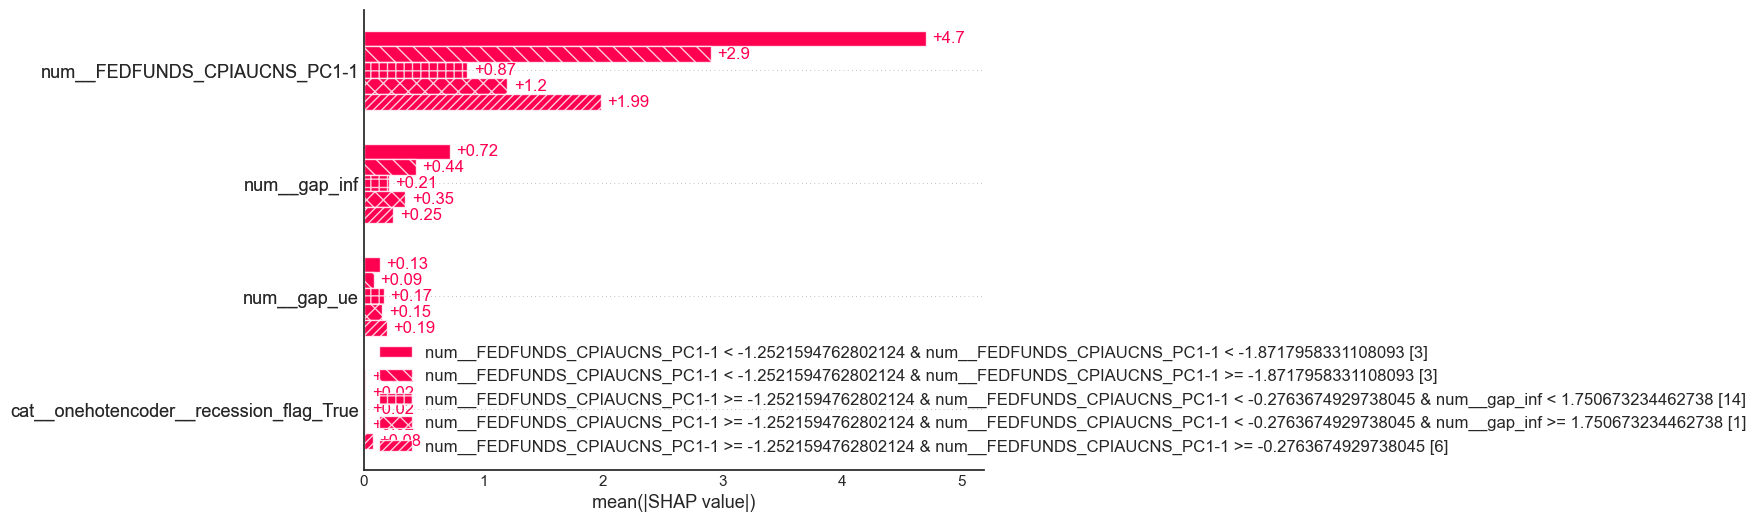

In [368]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [369]:
shap.force_plot(shap_values, plot_cmap = "PkYg")

In [370]:
explainer_tmp = None
shap_values_tmp = None

try:
    explainer_tmp = shap.Explainer(model)
    shap_values_tmp = explainer_tmp.shap_values(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

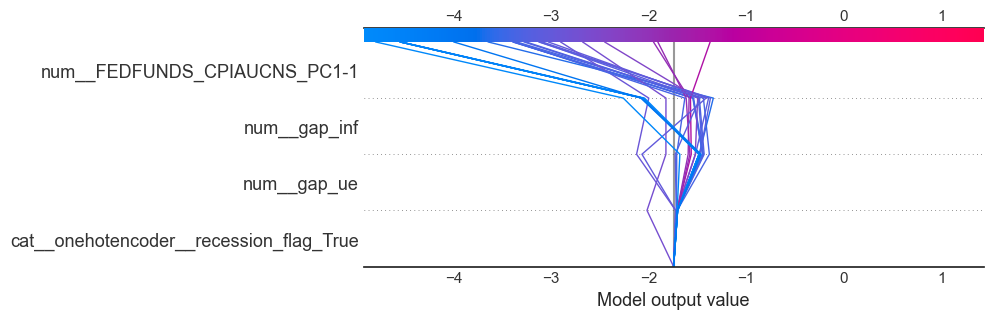

In [371]:
if (shap_values_tmp is not None):
    expected_value = explainer.expected_value
    shap.decision_plot(expected_value, shap_values_tmp, feature_names, ignore_warnings=True)

In [372]:
expected_value

-1.742823271386258

if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__FEDFUNDS-1"])

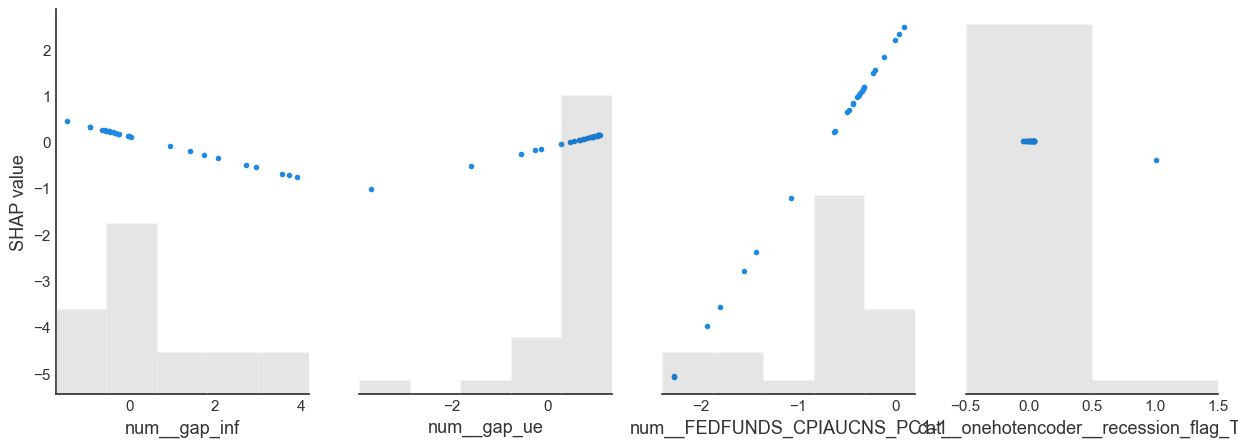

In [373]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)

# XGB

In [374]:
pipe_xgb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',xgb.XGBRegressor())]
)

param_xgb = {
    'model__learning_rate': uniform(0.01, 0.5),
    'model__n_estimators': randint(100, 300),
    'model__max_depth': randint(3, 10),
    'model__min_child_weight' : randint(1, 15),
    'model__subsample' : uniform(0.05, 1.0),
    'model__colsample_bytree' : uniform(0.05, 1.0),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
}


cv = RandomizedSearchCV(estimator = pipe_xgb, 
                        param_distributions = param_xgb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('XGB', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

XGB ) Best Accuracy Score: -0.13706217807671847 Parameters: {} {'model__colsample_bytree': 0.7758614974313065, 'model__learning_rate': 0.017249308005608803, 'model__max_depth': 9, 'model__min_child_weight': 5, 'model__n_estimators': 170, 'model__reg_alpha': 0.060069680454765316, 'model__subsample': 0.8547895388034705, 'model__verbose': -1}


In [375]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.9589753313052551

In [376]:
cv.best_estimator_.named_steps.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7758614974313065, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.017249308005608803, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=170, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [377]:
train_pred_xgb = cv.best_estimator_.predict(X_train)

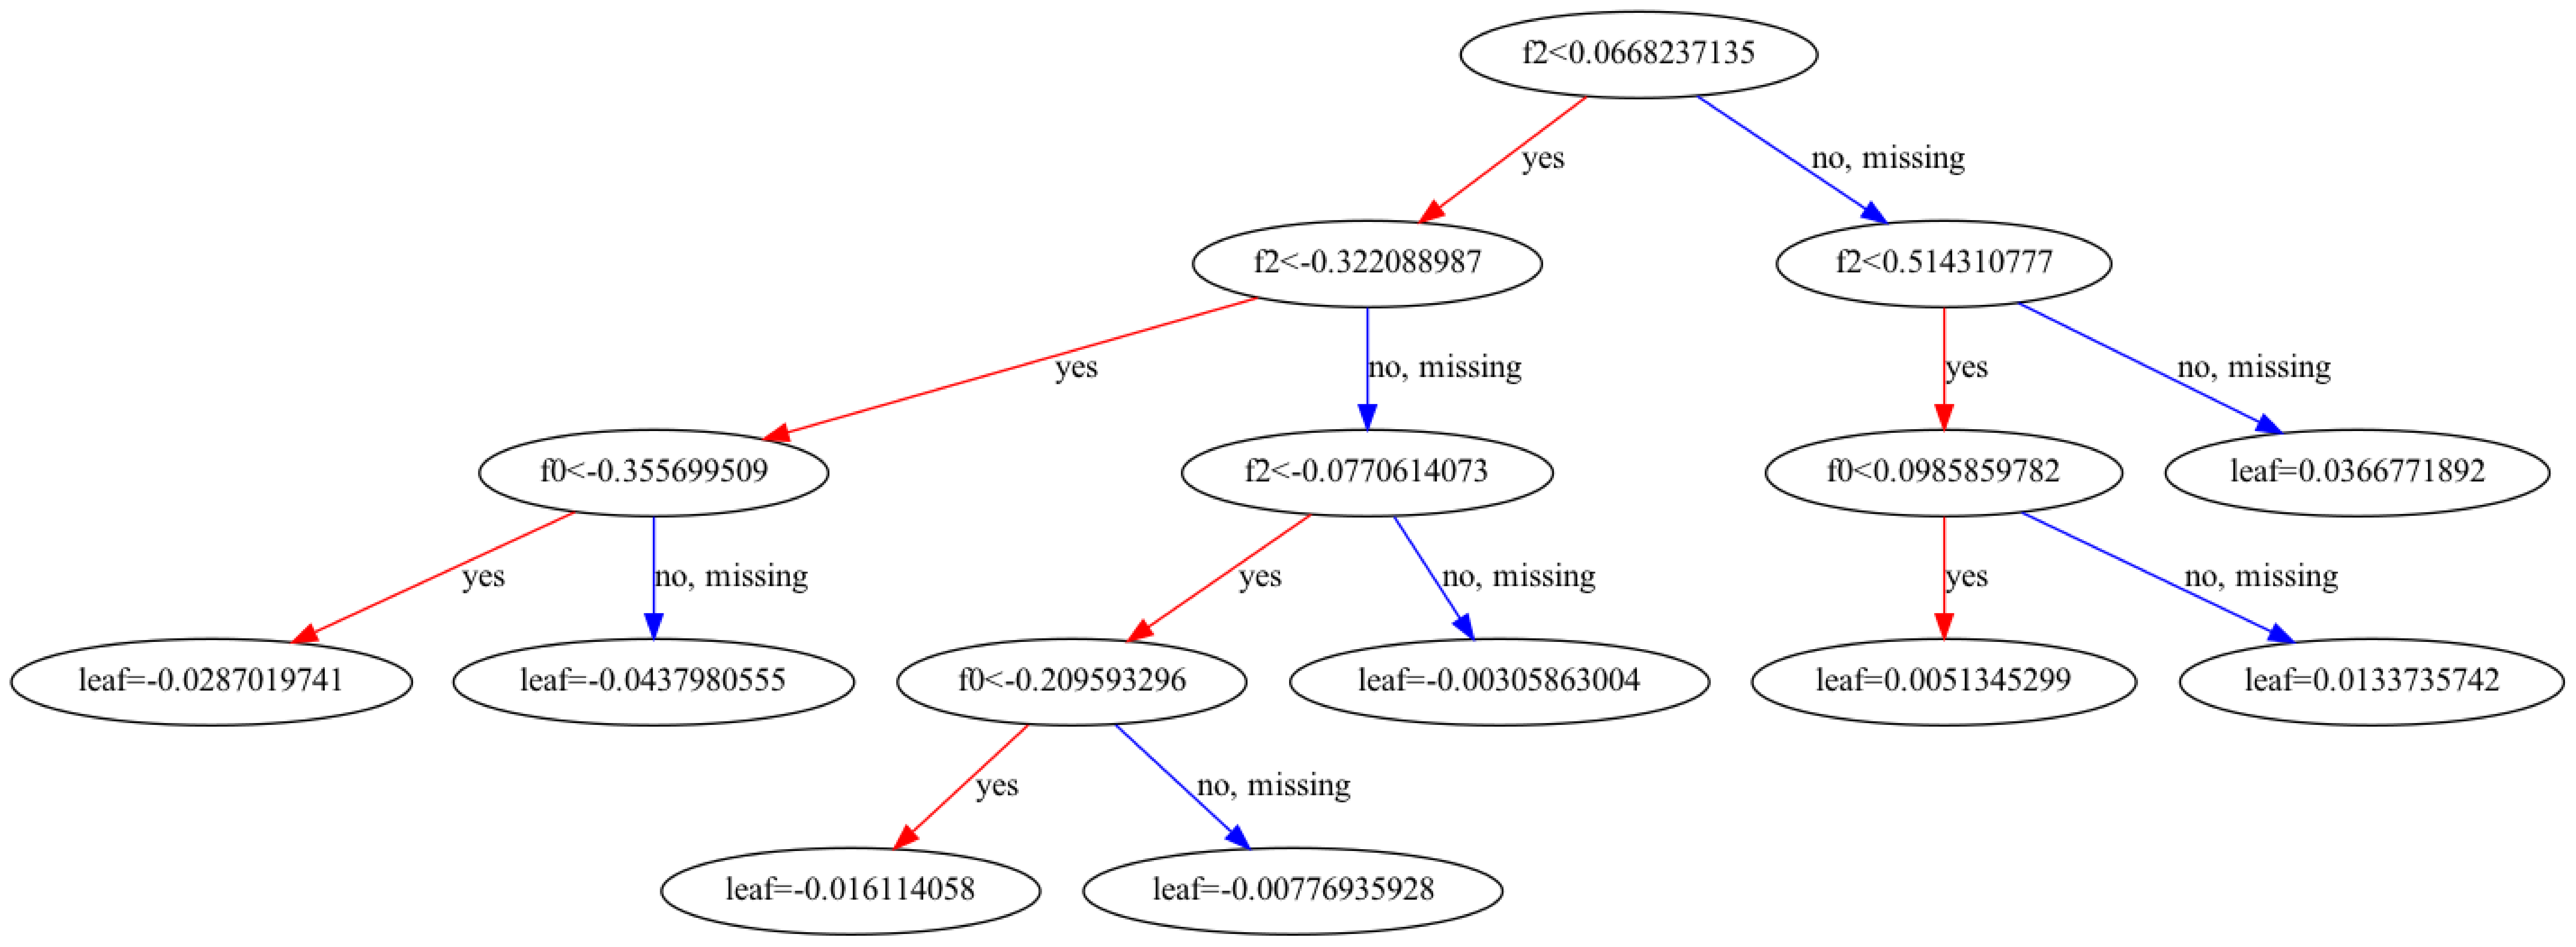

In [378]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(cv.best_estimator_.named_steps.model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

plt.show()

In [379]:
cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler_num',
                                                                                                RobustScaler()),
                                                                                               ('imp_num',
                                                                                                SimpleImputer())]),
                                                                               ['gap_inf',
                                                                                'gap_ue',
                                                                                'FEDFUNDS_CPIAUCNS_PC1-1']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('transformer',
                                                                                                ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                 OneHotEncoder(categories=[[False,
                                                                                                                                                            True]]...
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x168274790>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x168a38160>,
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16833d840>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16833d330>,
                                        'model__verbose': [-1]},
                   random_state=12, scoring='r2')

In [380]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

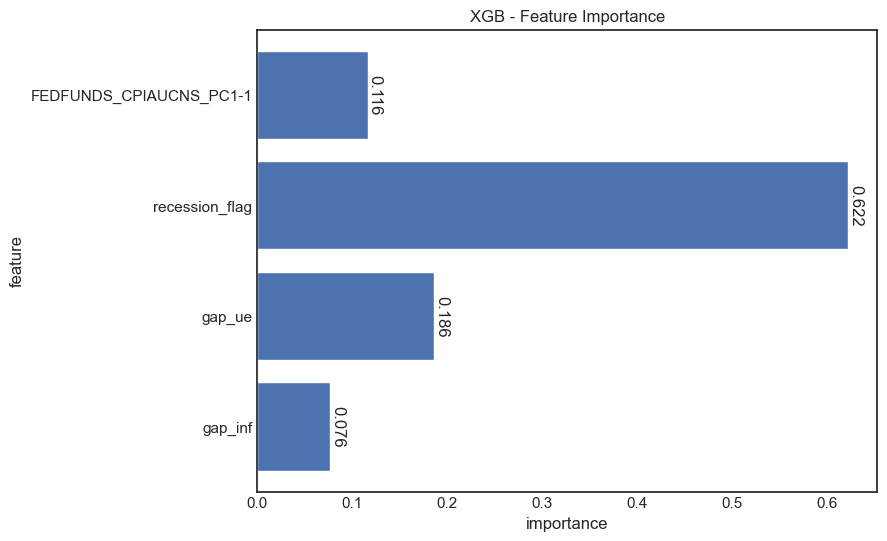

In [381]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.3f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('XGB - Feature Importance')
plt.grid(False)
plt.show()

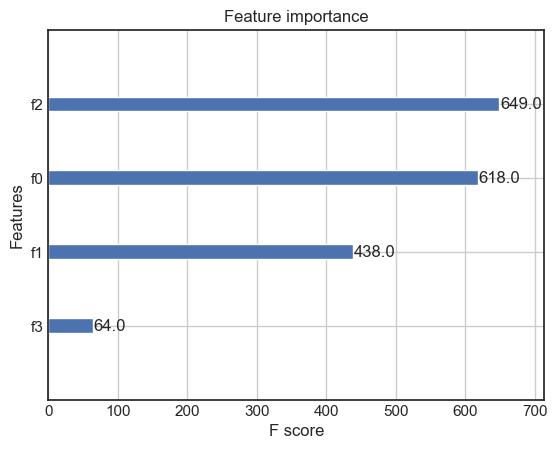

In [382]:
xgb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [383]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [384]:
test_pred_xgb = cv.best_estimator_.predict(X_test)
print('test_pred_xbg: ', test_pred_xgb.shape)

test_pred_xbg:  (27,)


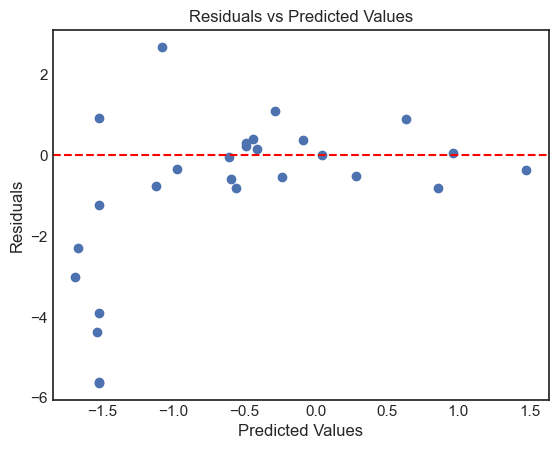

In [385]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_xgb, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [386]:
model_stats_df = model_results('xgb_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

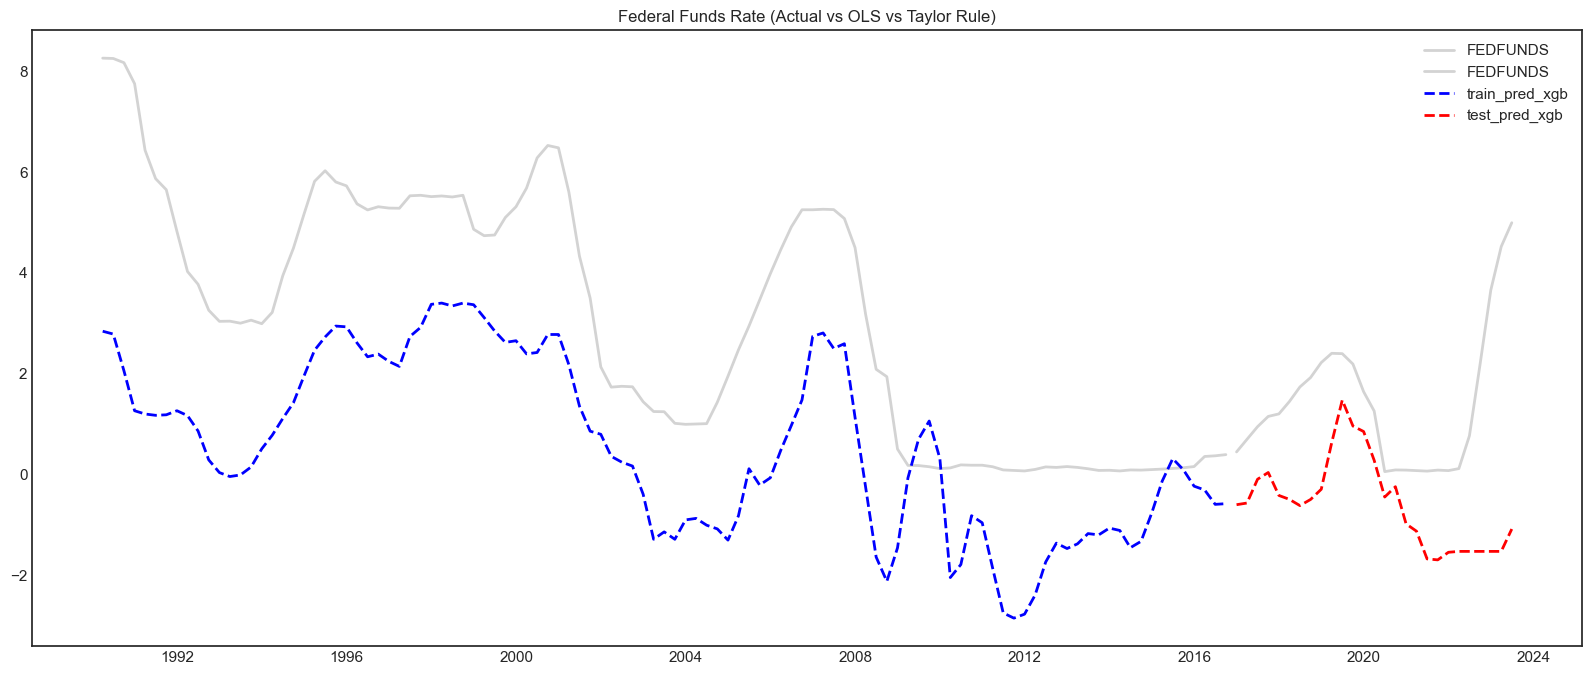

In [387]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_xgb, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_xgb, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_xgb","test_pred_xgb"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# AdaBoostRegressor

In [388]:
pipe_ada = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',AdaBoostRegressor())]
)

param_ada = {
    'model__learning_rate' : [0.01, 0.1, 0.5, 1.0],
    'model__n_estimators' : [50, 100, 150, 200, 250],
    'model__loss' : ["linear","exponential"],  
}


cv = RandomizedSearchCV(estimator = pipe_ada, 
                        param_distributions = param_ada,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('ADA', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

ADA ) Best Accuracy Score: 0.4474593811107166 Parameters: {} {'model__n_estimators': 200, 'model__loss': 'linear', 'model__learning_rate': 0.5}


In [389]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.9646720850884427

In [390]:
cv.best_estimator_.named_steps.model

AdaBoostRegressor(learning_rate=0.5, n_estimators=200)

In [391]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

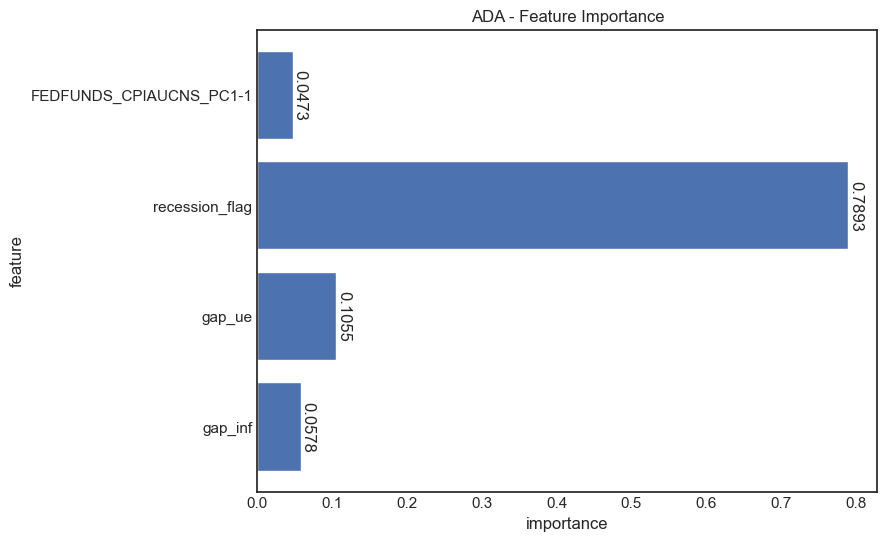

In [392]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.4f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('ADA - Feature Importance')
plt.grid(False)
plt.show()

In [393]:
train_pred_ada = cv.best_estimator_.predict(X_train)
model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train.shape[0], X_train.shape[1] , model_stats_df )

In [394]:
test_pred_ada = cv.best_estimator_.predict(X_test)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_test.shape[0], X_test.shape[1] , model_stats_df )

# tsa.SARIMAX

In [395]:
#model = sm.tsa.SARIMAX(y_train, order=(1,0,0), seasonal_order=(0, 0, 0, 4),enforce_stationarity=True, exog=X_train_trf)
model = sm.tsa.SARIMAX(y_train, order=(1,0,0), enforce_stationarity=True, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     FEDFUNDS_CPIAUCNS_PC1   No. Observations:                  107
Model:                  SARIMAX(1, 0, 0)   Log Likelihood                 -36.459
Date:                   Thu, 30 Nov 2023   AIC                             84.918
Time:                           08:30:43   BIC                            100.955
Sample:                       03-31-1990   HQIC                            91.419
                            - 09-30-2016                                         
Covariance Type:                     opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__gap_inf                               -1.3103      0.095    -13.859      0.000      -1.496      -1.125
num__gap_ue                                 1.3803      0.218      6.328      0.000       0.953       1.808
num__FEDFUNDS_CPIAUCNS_PC1-1                0.8373      0.132      6.321      0.000       0.578       1.097
cat__onehotencoder__recession_flag_True    -0.1451      0.104     -1.390      0.165      -0.350       0.060
ar.L1                                       0.9928      0.010    101.848      0.000       0.974       1.012
sigma2                                      0.1112      0.016      7.066      0.000       0.080       0.142
===================================================================================
Ljung-Box (L1) (Q):                   9.88   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.00   Prob(JB):                         0.58
Heteroskedasticity (H):               1.02   Skew:                            -0.22
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [396]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [397]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS_CPIAUCNS_PC1,mean,mean_se,mean_ci_lower,mean_ci_upper
1990-03-31,-1.185304,2.779752,-6.633518,4.262909
1990-06-30,-0.876521,2.779752,-6.324735,4.571692
1990-09-30,-1.976163,2.779752,-7.424377,3.472050
1990-12-31,-3.130982,2.779752,-8.579196,2.317231
1991-03-31,-2.686421,2.779752,-8.134635,2.761793
...,...,...,...,...
2015-09-30,2.453935,2.779752,-2.994278,7.902149
2015-12-31,2.260067,2.779752,-3.188146,7.708281
2016-03-31,1.765226,2.779752,-3.682988,7.213439
2016-06-30,1.545085,2.779752,-3.903129,6.993298


## Test

In [398]:
X_test_trf = t_fit.transform(X_test)
X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = test_df.index
X_test_trf.set_index('DATE', inplace=True)


y_test = test_df['FEDFUNDS']

In [399]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [400]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(27, 4)

In [401]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

,lower FEDFUNDS_CPIAUCNS_PC1,upper FEDFUNDS_CPIAUCNS_PC1
2016-12-31,-1.409245,-0.959325
2017-03-31,-2.164656,-1.530667
2017-06-30,-1.589723,-0.816041
2017-09-30,-1.451525,-0.561360
2017-12-31,-1.479393,-0.487720


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_CPIAUCNS_PC1_diff'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS_CPIAUCNS_PC1_diff'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS_CPIAUCNS_PC1_diff'], predict_ci['upper FEDFUNDS_CPIAUCNS_PC1_diff'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [402]:
model_stats_df = model_results('SARIMAX_train',y_train, train_pred_SARIM['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )
model_stats_df = model_results('SARIMAX_test', y_test, test_pred_SARIM['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )


# auto arima

In [403]:
import pmdarima as pm

In [404]:
# Initiate and Fit Model
arima_model = pm.auto_arima(y = y_train, 
                            X = X_train_trf,
                            test='adf', 
                            seasonal=True, 
                            error_action='ignore',  
                            suppress_warnings=True,
                            stepwise=True, trace=True)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=77.100, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=224.370, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=201.622, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=262.934, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=72.698, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=203.565, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=73.532, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=66.986, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=166.903, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=65.184, Time=0.11 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=79.552, Time=0.12 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=67.723, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=65.533, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=70.434, Time=0.10

In [405]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 -21.809
Date:                Thu, 30 Nov 2023   AIC                             63.618
Time:                        08:30:45   BIC                             90.347
Sample:                    03-31-1990   HQIC                            74.454
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__gap_inf                               -1.3972      0.062    -22.556      0.000      -1.519      -1.276
num__gap_ue                                 0.6442      0.275      2.339      0.019       0.104       1.184
num__FEDFUNDS_CPIAUCNS_PC1-1                0.3202      0.197      1.626      0.104      -0.066       0.706
cat__onehotencoder__recession_flag_True     0.0671      0.066      1.015      0.310      -0.062       0.197
ar.L1                                       1.4959      0.199      7.532      0.000       1.107       1.885
ar.L2                                      -0.5277      0.196     -2.698      0.007      -0.911      -0.144
ma.L1                                      -0.0040      0.213     -0.019      0.985      -0.421       0.413
ma.L2                                       0.0781      0.124      0.632      0.528      -0.164       0.320
ma.L3                                       0.2999      0.104      2.880      0.004       0.096       0.504
sigma2                                      0.0842      0.011      7.464      0.000       0.062       0.106
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 5.32
Prob(Q):                              0.84   Prob(JB):                         0.07
Heteroskedasticity (H):               1.08   Skew:                            -0.28
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [406]:
predict, confint = arima_model.predict_in_sample(X=X_train_trf, return_conf_int=True)
train_pred_pmdarima = pd.DataFrame(predict)
train_pred_pmdarima.columns = ['mean']
train_pred_pmdarima['lower'] = confint[:,0]
train_pred_pmdarima['upper'] = confint[:,1]
train_pred_pmdarima.shape

(107, 3)

In [407]:
forecast, confint = arima_model.predict(len(y_test) , X=X_test_trf, return_conf_int=True)
test_pred_pmdarima = pd.DataFrame(forecast)
test_pred_pmdarima.columns = ['mean']
test_pred_pmdarima['lower'] = confint[:,0]
test_pred_pmdarima['upper'] = confint[:,1]
test_pred_pmdarima.shape

(27, 3)

In [408]:
model_stats_df = model_results('pmdarima_train',y_train, train_pred_pmdarima['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )
model_stats_df = model_results('pmdarima_test', y_test, test_pred_pmdarima['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

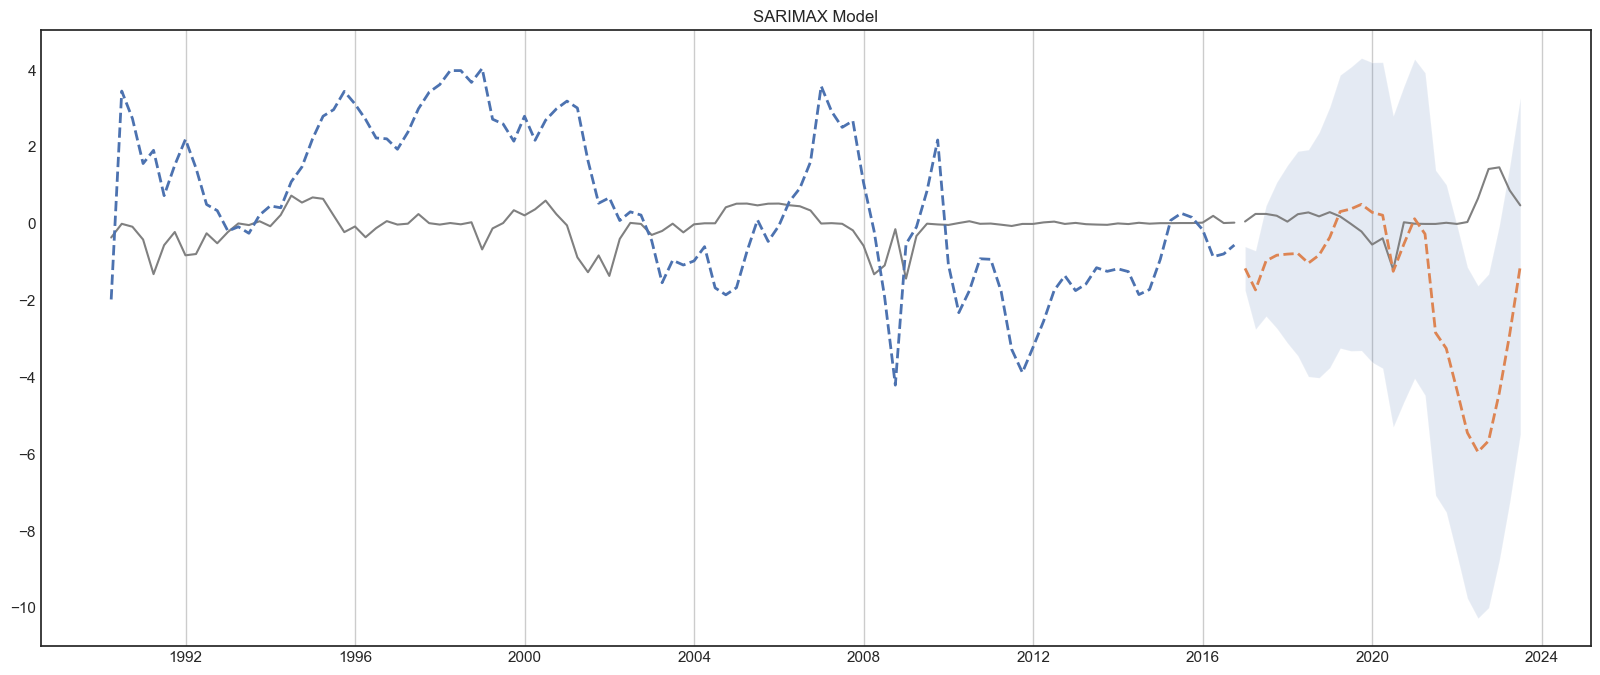

In [409]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'gray')
ax.plot(train_pred_pmdarima.index, train_pred_pmdarima['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_pmdarima.index, test_pred_pmdarima['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_pmdarima.index, test_pred_pmdarima['lower'], test_pred_pmdarima['upper'], alpha=0.15)

ax.set(title='SARIMAX Model');

# Result

In [410]:
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,0.0328,0.0279,0.9061,0.9519
1,ffef_tr_test,-13.6332,-13.9446,2.2484,1.4995
2,ffef_tr2_train,-0.3337,-0.3406,1.2494,1.1178
3,ffef_tr2_test,0.5059,0.4954,0.0759,0.2755
4,Naive_train,-0.0001,-0.0001,0.9369,0.9680
5,Naive_test,-0.0633,-0.0633,0.1634,0.4042
6,ols_train,0.8884,0.8852,0.4261,0.6528
7,ols_test,0.7935,0.7665,1.3593,1.1659
8,glm_train,0.4222,0.4054,2.2069,1.4856
9,glm_test,-0.9193,-1.1697,12.6329,3.5543


In [411]:
#X_train_trf

long_df: (428, 3)


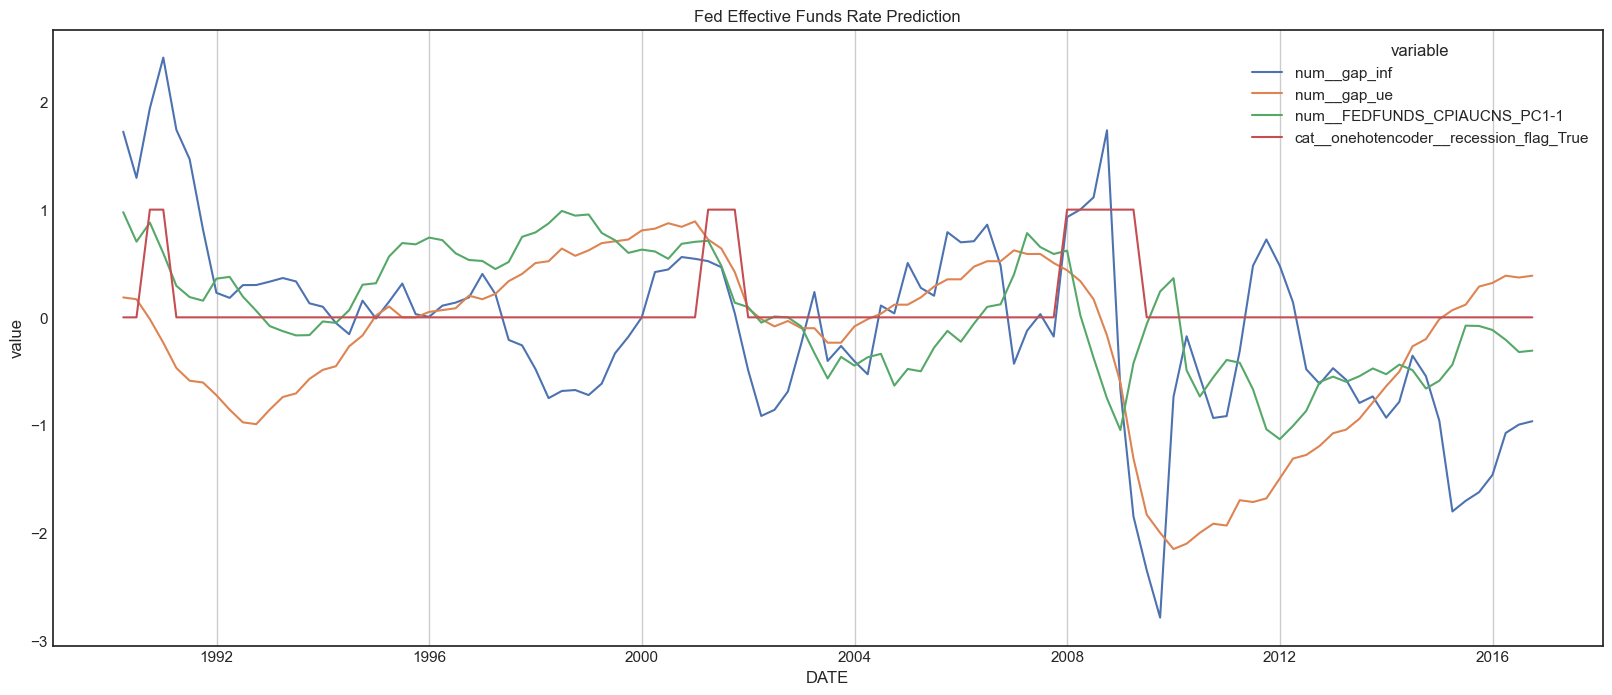

In [412]:
# Long 
long_df = X_train_trf.copy()
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['DATE'])
#long_df = long_df[['DATE','FEDFUNDS','ffef_tr','gap_inf','gap_gdp']].melt(id_vars=['DATE'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
#ax.plot(long_df['observation_date'], long_df['value'], color='variable')
sns.lineplot(x = 'DATE', y = 'value', data=long_df, hue='variable')

ax.set(title='Fed Effective Funds Rate Prediction');